In [127]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt

%matplotlib inline
pd.set_option('display.max_columns', 100)

In [128]:
modelo=pd.read_csv('data/modelo.csv',low_memory=False)

In [129]:
modelo.head()

,timestamp,event,person,url,sku,model,condition,storage,color,skus,search_term,staticpage,campaign_source,search_engine,channel,new_vs_returning,city,region,country,device_type,screen_resolution,operating_system_version,browser_version
0,2018-05-18 00:11:59,viewed product,4886f805,NaN,9288.0,Samsung Galaxy J7 Prime,Excelente,32GB,Dourado,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-05-18 00:11:27,viewed product,ad93850f,NaN,304.0,iPhone 5s,Muito Bom,32GB,Cinza espacial,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2018-05-18 00:11:16,viewed product,0297fc1e,NaN,6888.0,iPhone 6S,Muito Bom,64GB,Prateado,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2018-05-18 00:11:14,viewed product,2d681dd8,NaN,11890.0,iPhone 7,Bom,128GB,Vermelho,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2018-05-18 00:11:09,viewed product,cccea85e,NaN,7517.0,LG G4 H818P,Excelente,32GB,Branco,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [130]:
modelo['model'].value_counts()

iPhone 6                                     107262
iPhone 5s                                    101399
iPhone 6S                                     97227
iPhone 7                                      58991
Samsung Galaxy S7 Edge                        50304
iPhone 7 Plus                                 45067
Samsung Galaxy S7                             39617
iPhone 6S Plus                                37972
iPhone SE                                     37032
Samsung Galaxy S8                             32753
iPhone 6 Plus                                 32253
Samsung Galaxy S6 Edge                        30823
Samsung Galaxy J5                             29691
iPhone 5c                                     28008
Samsung Galaxy S6 Flat                        27768
Samsung Galaxy J7 Prime                       25338
Motorola Moto G4 Plus                         25264
Samsung Galaxy S8 Plus                        20987
iPhone 5                                      18551
Samsung Gala

In [131]:
modelo.shape

(2341681, 23)

In [132]:
modelo.isnull().sum()

timestamp                         0
event                             0
person                            0
url                         2150550
sku                         1021151
model                       1020168
condition                   1021151
storage                     1021151
color                       1021151
skus                        1835732
search_term                 2227918
staticpage                  2330480
campaign_source             2150395
search_engine               2235275
channel                     2137612
new_vs_returning            2137612
city                        2137612
region                      2137612
country                     2137612
device_type                 2137612
screen_resolution           2137615
operating_system_version    2137612
browser_version             2137612
dtype: int64

In [133]:
modelo.drop(['url','skus','channel','staticpage','search_engine','device_type','campaign_source','country','region','search_term','new_vs_returning','city','region','screen_resolution','operating_system_version','browser_version'], axis=1, inplace=True)

In [134]:
training= pd.read_csv('data/training.csv',low_memory=False)

# Armado del modelo

In [135]:
import calendar
modelo['timestamp'] = pd.to_datetime(modelo['timestamp'])

### Fechas

In [136]:
modelo['dia']=modelo['timestamp'].dt.dayofyear
modelo['dia_de_la_semana']=modelo['timestamp'].dt.dayofweek
modelo['nombre_del_dia']=modelo['timestamp'].dt.day_name()
modelo['hora']=modelo['timestamp'].dt.hour

### Horas distintas

In [137]:
modelo['horas_distintas']=modelo['person'].map(modelo.groupby('person')['hora'].nunique())

### Eventos en los ultimos dias

### Tipos de eventos por persona

In [138]:
df_aux=modelo.groupby(['person','event'])['event'].size().unstack('event')
modelo=pd.merge(modelo,df_aux,on='person',how='left')

### Dias distintos en el ultimo mes

In [139]:
modelo['dias_distintos'] = modelo['person'].map(modelo.groupby(['person',(modelo['timestamp'].dt.month==5) ] )['dia'].nunique().unstack()[True]) 

In [140]:
modelo['dias_distintos_ultima_semana']=modelo['person'].map(modelo.groupby(['person',(modelo['timestamp'].dt.month==5)&(modelo['timestamp'].dt.day>23) ] )['dia'].nunique().unstack()[True])  

### Dias distintos de la semana

In [141]:
modelo['dias_distintos_de_la_semana']=modelo['person'].map(modelo.groupby('person')['dia_de_la_semana'].nunique())    

In [142]:
modelo['dias_distintos_de_la_semana_last_month']=modelo['person'].map(modelo.groupby(['person',(modelo['timestamp'].dt.month==5) ])['dia_de_la_semana'].nunique().unstack()[True])

### Ultima visita

In [143]:
modelo['ultima_visita']=modelo['person'].map(modelo.groupby('person' )['dia'].max())  

### Compras por dia de la semana

In [144]:
df_aux=modelo.groupby(['person','nombre_del_dia']).size().reset_index()
compras_por_dia_semana=modelo.loc[modelo['event']=='conversion']['nombre_del_dia'].value_counts().to_dict()
df_aux['compras_por_dia_semana']=df_aux[0]*df_aux['nombre_del_dia'].apply(lambda x: compras_por_dia_semana.get(x))
modelo['compras_por_dia_semana']=modelo['person'].map(df_aux.groupby('person')['compras_por_dia_semana'].sum())  

### Modelos y marcas de celuares distintos vistos

In [145]:
modelo['modelos_distintos_vistos']= modelo['person'].map( modelo.groupby('person')['model'].nunique())

modelo['marca']=modelo['model'].str.split().str.get(0)
modelo['marcas_distintas']=modelo['person'].map(modelo.groupby('person')['marca'].nunique()) 

### Visitas maximas de un mismo celular

In [146]:
modelo['celular_mas_visto']=modelo['person'].map(modelo.groupby(['person','model']).size().groupby('person').max()) 

### Relacion de colores por modelo

In [147]:
modelo['color']=modelo['color'].fillna(0)
modelo['modelos_por_color']=modelo['person'].map(modelo.groupby('person')['model'].nunique()/(modelo.groupby('person')['color'].nunique()))

### Eventos distintos

In [148]:
modelo['eventos_distintos']=modelo['person'].map(modelo.groupby('person')['event'].nunique())   

### Relacion de eventos sobre el total del usuario

In [149]:
#df_aux = modelo.groupby(['person','event']).size().unstack().fillna(0).astype(int)
#df_aux = df_aux.div(df_aux.sum(axis=1), axis=0)
#modelo = modelo.merge(df_aux, how='left', on='person')
#modelo.head()
#df_aux.head()

### Campaña en la ultima semana

In [150]:
modelo['campaña_ultima_semana']=modelo['person'].map(modelo.groupby(['person',(modelo['timestamp'].dt.month==5) & (modelo['timestamp'].dt.day>23) & (modelo['event']=="ad campaign hit")]).size().unstack()[True])

#Disminuye
#modelo['campaña_ultimos_3']=modelo['person'].map(modelo.groupby(['person',(modelo['timestamp'].dt.month==5) & (modelo['timestamp'].dt.day>27) & (modelo['event']=="ad campaign hit")]).size().unstack()[True])
#Disminuye
#modelo['campaña_ultimo_dia']=modelo['person'].map(modelo.groupby(['person',(modelo['timestamp'].dt.month==5) & (modelo['timestamp'].dt.day>29) & (modelo['event']=="ad campaign hit")]).size().unstack()[True])

### Visitas

In [151]:
modelo['total_visitas_usuario'] = modelo.groupby('person')['person'].transform('count')

In [152]:
modelo['visitas_ultimo_mes']=modelo['person'].map(modelo.groupby(['person',(modelo['timestamp'].dt.month)==5]).size().unstack()[True])

modelo['visitas_ultimos_15']=modelo['person'].map(modelo.groupby(['person', (modelo['timestamp'].dt.month==5)& (modelo['timestamp'].dt.day>15)]).size().unstack()[True])

modelo['visitas_ultima_semana']=modelo['person'].map(modelo.groupby(['person', (modelo['timestamp'].dt.month==5)& (modelo['timestamp'].dt.day>23)]).size().unstack()[True])

modelo['visitas_ultimos_3']=modelo['person'].map(modelo.groupby(['person', (modelo['timestamp'].dt.month==5)& (modelo['timestamp'].dt.day>27)]).size().unstack()[True])

modelo['visitas_ultimo_dia']=modelo['person'].map(modelo.groupby(['person', (modelo['timestamp'].dt.month==5)& (modelo['timestamp'].dt.day>29)]).size().unstack()[True])

modelo['visitas_ultimos_2']=modelo['person'].map(modelo.groupby(['person', (modelo['timestamp'].dt.month==5)& (modelo['timestamp'].dt.day>28)]).size().unstack()[True])

#11
modelo['visitas_ultimos_4']=modelo['person'].map(modelo.groupby(['person', (modelo['timestamp'].dt.month==5)& (modelo['timestamp'].dt.day>26)]).size().unstack()[True])

### Brand Listing (Disminuye)

#Agrego
modelo['total_brand']=modelo['person'].map(modelo.groupby(['person','event']).size().unstack()['brand listing'])
#Agrego
modelo['brand_ultimo_mes']=modelo['person'].map(modelo.groupby(['person','event',modelo['timestamp'].dt.month==5 ]).size().unstack()[True].unstack()['brand listing'])   
#Agrego
modelo['brand_ultima_semana']=modelo['person'].map(modelo.groupby(['person','event',(modelo['timestamp'].dt.month==5)& (modelo['timestamp'].dt.day>23)]).size().unstack()[True].unstack()['brand listing'])
#Agrego
modelo['brand_ultimos_15']=modelo['person'].map(modelo.groupby(['person','event',(modelo['timestamp'].dt.month==5)& (modelo['timestamp'].dt.day>15)]).size().unstack()[True].unstack()['brand listing'])
#Agrego
modelo['brand_ultimos_3']=modelo['person'].map(modelo.groupby(['person','event',(modelo['timestamp'].dt.month==5)& (modelo['timestamp'].dt.day>27)]).size().unstack()[True].unstack()['brand listing'])
#Agrego
modelo['brand_ultimo_dia']=modelo['person'].map(modelo.groupby(['person','event',(modelo['timestamp'].dt.month==5)& (modelo['timestamp'].dt.day>29)]).size().unstack()[True].unstack()['brand listing'])

### Searched Products (disminuye)

#Agrego
modelo['total_search']=modelo['person'].map(modelo.groupby(['person','event']).size().unstack()['searched products'])
#Agrego
modelo['search_ultimo_mes']=modelo['person'].map(modelo.groupby(['person','event',modelo['timestamp'].dt.month==5 ]).size().unstack()[True].unstack()['searched products'])   
#Agrego
modelo['search_ultima_semana']=modelo['person'].map(modelo.groupby(['person','event',(modelo['timestamp'].dt.month==5)& (modelo['timestamp'].dt.day>23)]).size().unstack()[True].unstack()['searched products'])
#Agrego
modelo['search_ultimos_15']=modelo['person'].map(modelo.groupby(['person','event',(modelo['timestamp'].dt.month==5)& (modelo['timestamp'].dt.day>15)]).size().unstack()[True].unstack()['searched products'])
#Agrego
modelo['search_ultimos_3']=modelo['person'].map(modelo.groupby(['person','event',(modelo['timestamp'].dt.month==5)& (modelo['timestamp'].dt.day>27)]).size().unstack()[True].unstack()['searched products'])
#Agrego
modelo['search_ultimo_dia']=modelo['person'].map(modelo.groupby(['person','event',(modelo['timestamp'].dt.month==5)& (modelo['timestamp'].dt.day>29)]).size().unstack()[True].unstack()['searched products'])

### Checkouts

In [153]:
modelo['total_checkout']=modelo['person'].map(modelo.groupby(['person','event']).size().unstack()['checkout'])

modelo['checkouts_ultimo_mes']=modelo['person'].map(modelo.groupby(['person','event',modelo['timestamp'].dt.month==5 ]).size().unstack()[True].unstack()['checkout'])   

modelo['checkouts_ultima_semana']=modelo['person'].map(modelo.groupby(['person','event',(modelo['timestamp'].dt.month==5)& (modelo['timestamp'].dt.day>23)]).size().unstack()[True].unstack()['checkout'])

modelo['checkouts_ultimos_15']=modelo['person'].map(modelo.groupby(['person','event',(modelo['timestamp'].dt.month==5)& (modelo['timestamp'].dt.day>15)]).size().unstack()[True].unstack()['checkout'])

modelo['checkouts_ultimos_3']=modelo['person'].map(modelo.groupby(['person','event',(modelo['timestamp'].dt.month==5)& (modelo['timestamp'].dt.day>27)]).size().unstack()[True].unstack()['checkout'])

modelo['checkouts_ultimo_dia']=modelo['person'].map(modelo.groupby(['person','event',(modelo['timestamp'].dt.month==5)& (modelo['timestamp'].dt.day>29)]).size().unstack()[True].unstack()['checkout'])
modelo['checkouts_ultimos_2']=modelo['person'].map(modelo.groupby(['person','event',(modelo['timestamp'].dt.month==5)& (modelo['timestamp'].dt.day>28)]).size().unstack()[True].unstack()['checkout'])
modelo['checkouts_ultimos_5']=modelo['person'].map(modelo.groupby(['person','event',(modelo['timestamp'].dt.month==5)& (modelo['timestamp'].dt.day>25)]).size().unstack()[True].unstack()['checkout'])
modelo['checkouts_ultimos_4']=modelo['person'].map(modelo.groupby(['person','event',(modelo['timestamp'].dt.month==5)& (modelo['timestamp'].dt.day>26)]).size().unstack()[True].unstack()['checkout'])


In [154]:
#Agrego
modelo['checkouts_ultimos_16']=modelo['person'].map(modelo.groupby(['person','event',(modelo['timestamp'].dt.month==5)& (modelo['timestamp'].dt.day>14)]).size().unstack()[True].unstack()['checkout'])
modelo['checkouts_ultimos_18']=modelo['person'].map(modelo.groupby(['person','event',(modelo['timestamp'].dt.month==5)& (modelo['timestamp'].dt.day>12)]).size().unstack()[True].unstack()['checkout'])
modelo['checkouts_ultimos_20']=modelo['person'].map(modelo.groupby(['person','event',(modelo['timestamp'].dt.month==5)& (modelo['timestamp'].dt.day>10)]).size().unstack()[True].unstack()['checkout'])
modelo['checkouts_ultimos_22']=modelo['person'].map(modelo.groupby(['person','event',(modelo['timestamp'].dt.month==5)& (modelo['timestamp'].dt.day>8)]).size().unstack()[True].unstack()['checkout'])
modelo['checkouts_ultimos_24']=modelo['person'].map(modelo.groupby(['person','event',(modelo['timestamp'].dt.month==5)& (modelo['timestamp'].dt.day>6)]).size().unstack()[True].unstack()['checkout'])
modelo['checkouts_ultimos_26']=modelo['person'].map(modelo.groupby(['person','event',(modelo['timestamp'].dt.month==5)& (modelo['timestamp'].dt.day>4)]).size().unstack()[True].unstack()['checkout'])
modelo['checkouts_ultimos_28']=modelo['person'].map(modelo.groupby(['person','event',(modelo['timestamp'].dt.month==5)& (modelo['timestamp'].dt.day>2)]).size().unstack()[True].unstack()['checkout'])


In [155]:
modelo['checkouts_ultimos_6']=modelo['person'].map(modelo.groupby(['person','event',(modelo['timestamp'].dt.month==5)& (modelo['timestamp'].dt.day>24)]).size().unstack()[True].unstack()['checkout'])
modelo['checkouts_ultimos_8']=modelo['person'].map(modelo.groupby(['person','event',(modelo['timestamp'].dt.month==5)& (modelo['timestamp'].dt.day>22)]).size().unstack()[True].unstack()['checkout'])
modelo['checkouts_ultimos_9']=modelo['person'].map(modelo.groupby(['person','event',(modelo['timestamp'].dt.month==5)& (modelo['timestamp'].dt.day>21)]).size().unstack()[True].unstack()['checkout'])
modelo['checkouts_ultimos_10']=modelo['person'].map(modelo.groupby(['person','event',(modelo['timestamp'].dt.month==5)& (modelo['timestamp'].dt.day>20)]).size().unstack()[True].unstack()['checkout'])
modelo['checkouts_ultimos_11']=modelo['person'].map(modelo.groupby(['person','event',(modelo['timestamp'].dt.month==5)& (modelo['timestamp'].dt.day>19)]).size().unstack()[True].unstack()['checkout'])
modelo['checkouts_ultimos_12']=modelo['person'].map(modelo.groupby(['person','event',(modelo['timestamp'].dt.month==5)& (modelo['timestamp'].dt.day>18)]).size().unstack()[True].unstack()['checkout'])
modelo['checkouts_ultimos_14']=modelo['person'].map(modelo.groupby(['person','event',(modelo['timestamp'].dt.month==5)& (modelo['timestamp'].dt.day>16)]).size().unstack()[True].unstack()['checkout'])
modelo['checkouts_ultimos_17']=modelo['person'].map(modelo.groupby(['person','event',(modelo['timestamp'].dt.month==5)& (modelo['timestamp'].dt.day>13)]).size().unstack()[True].unstack()['checkout'])


In [156]:
modelo['dia_de_la_semana'].value_counts()

2    423333
3    418433
1    406008
0    331889
4    301024
5    245292
6    215702
Name: dia_de_la_semana, dtype: int64

In [157]:
modelo['checkouts_lunes']=modelo['person'].map(modelo.groupby(['person','event',(modelo['dia_de_la_semana']==0)]).size().unstack()[True].unstack()['checkout'])
modelo['checkouts_martes']=modelo['person'].map(modelo.groupby(['person','event',(modelo['dia_de_la_semana']==1)]).size().unstack()[True].unstack()['checkout'])
modelo['checkouts_miercoles']=modelo['person'].map(modelo.groupby(['person','event',(modelo['dia_de_la_semana']==2)]).size().unstack()[True].unstack()['checkout'])
modelo['checkouts_jueves']=modelo['person'].map(modelo.groupby(['person','event',(modelo['dia_de_la_semana']==3)]).size().unstack()[True].unstack()['checkout'])
modelo['checkouts_viernes']=modelo['person'].map(modelo.groupby(['person','event',(modelo['dia_de_la_semana']==4)]).size().unstack()[True].unstack()['checkout'])
modelo['checkouts_sabado']=modelo['person'].map(modelo.groupby(['person','event',(modelo['dia_de_la_semana']==5)]).size().unstack()[True].unstack()['checkout'])
modelo['checkouts_domingo']=modelo['person'].map(modelo.groupby(['person','event',(modelo['dia_de_la_semana']==6)]).size().unstack()[True].unstack()['checkout'])


In [158]:
modelo['checkouts_finde'] = modelo['person'].map(modelo.groupby(['person','event',(modelo['dia_de_la_semana']>=4)]).size().unstack()[True].unstack()['checkout'])
modelo['checkouts_semana'] = modelo['person'].map(modelo.groupby(['person','event',(modelo['dia_de_la_semana']<4)]).size().unstack()[True].unstack()['checkout'])

modelo['checkouts_finde'] =  modelo['person'].map(modelo.groupby(['person','event',(modelo['dia_de_la_semana']>=4)]).size().unstack()[True].unstack()['conversion'])
modelo['checkouts_semana'] =  modelo['person'].map(modelo.groupby(['person','event',(modelo['dia_de_la_semana']<4)]).size().unstack()[True].unstack()['conversion'])

modelo['visitas_finde'] = modelo['person'].map(modelo.groupby(['person', (modelo['timestamp'].dt.month==5)& (modelo['dia_de_la_semana']>=4)]).size().unstack()[True])

modelo['visitas_semana'] = modelo['person'].map(modelo.groupby(['person', (modelo['timestamp'].dt.month==5)& (modelo['dia_de_la_semana']>=4)]).size().unstack()[True])



In [159]:
modelo.tail()

,timestamp,event,person,sku,model,condition,storage,color,dia,dia_de_la_semana,nombre_del_dia,hora,horas_distintas,ad campaign hit,brand listing,checkout,conversion,generic listing,lead,search engine hit,searched products,staticpage,viewed product,visited site,dias_distintos,dias_distintos_ultima_semana,dias_distintos_de_la_semana,dias_distintos_de_la_semana_last_month,ultima_visita,compras_por_dia_semana,modelos_distintos_vistos,marca,marcas_distintas,celular_mas_visto,modelos_por_color,eventos_distintos,campaña_ultima_semana,total_visitas_usuario,visitas_ultimo_mes,visitas_ultimos_15,visitas_ultima_semana,visitas_ultimos_3,visitas_ultimo_dia,visitas_ultimos_2,total_checkout,checkouts_ultimo_mes,checkouts_ultima_semana,checkouts_ultimos_15,checkouts_ultimos_3,checkouts_ultimo_dia,checkouts_ultimos_2,checkouts_ultimos_5,checkouts_ultimos_4,checkouts_ultimos_16,checkouts_ultimos_18,checkouts_ultimos_20,checkouts_ultimos_22,checkouts_ultimos_24,checkouts_ultimos_26,checkouts_ultimos_28,checkouts_ultimos_6,checkouts_ultimos_8,checkouts_ultimos_9,checkouts_ultimos_10,checkouts_ultimos_11,checkouts_ultimos_12,checkouts_ultimos_14,checkouts_ultimos_17,checkouts_lunes,checkouts_martes,checkouts_miercoles,checkouts_jueves,checkouts_viernes,checkouts_sabado,checkouts_domingo,checkouts_finde,checkouts_semana,visitas_finde,visitas_semana
2341676,2018-05-31 13:05:04,lead,9b1ba18d,NaN,Motorola Moto Z2 Play,NaN,NaN,0,151,3,Thursday,13,4,13.0,3.0,NaN,NaN,11.0,1.0,11.0,11.0,NaN,58.0,2.0,1.0,1.0,1,1.0,151,156750,25,Motorola,5,11.0,2.777778,8,13.0,110,110.0,110.0,110.0,110.0,110.0,110.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2341677,2018-05-31 14:49:59,lead,27b90284,NaN,Asus Zenfone 3 Max 16 GB,NaN,NaN,0,151,3,Thursday,14,6,6.0,3.0,NaN,NaN,NaN,1.0,1.0,NaN,1.0,250.0,4.0,1.0,1.0,1,1.0,151,379050,35,Asus,9,35.0,1.842105,7,6.0,266,266.0,266.0,266.0,266.0,266.0,266.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2341678,2018-05-31 15:21:09,lead,a0b57323,NaN,Motorola Moto Z2 Play,NaN,NaN,0,151,3,Thursday,15,16,NaN,8.0,NaN,NaN,3.0,5.0,1.0,NaN,NaN,614.0,22.0,7.0,7.0,7,7.0,151,571938,27,Motorola,4,118.0,1.500000,6,NaN,653,653.0,653.0,653.0,136.0,93.0,134.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,517.0,517.0
2341679,2018-05-31 10:34:49,lead,ff9fc164,NaN,Samsung Galaxy On 7,NaN,NaN,0,151,3,Thursday,10,14,6.0,NaN,1.0,NaN,9.0,3.0,4.0,39.0,1.0,16.0,11.0,4.0,3.0,4,4.0,151,124952,5,Samsung,2,9.0,0.833333,9,5.0,90,90.0,90.0,86.0,86.0,80.0,86.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,4.0,4.0
2341680,2018-05-05 07:49:58,lead,6ca3126e,NaN,Samsung Galaxy S Duos 2,NaN,NaN,0,125,5,Saturday,7,24,424.0,191.0,47.0,5.0,196.0,2.0,245.0,3.0,8.0,744.0,141.0,20.0,2.0,7,7.0,151,2112532,58,Samsung,6,170.0,4.461538,11,9.0,2006,388.0,82.0,64.0,64.0,64.0,64.0,47.0,7.0,3.0,6.0,3.0,3.0,3.0,3.0,3.0,6.0,6.0,6.0,6.0,6.0,6.0,7.0,3.0,3.0,3.0,6.0,6.0,6.0,6.0,6.0,5.0,8.0,14.0,2.0,14.0,3.0,1.0,3.0,2.0,141.0,141.0


### Compras

In [160]:
modelo['total_compras']=modelo['person'].map(modelo.groupby(['person','event']).size().unstack()['conversion'])

In [161]:
modelo['compras_ultimo_mes']=modelo['person'].map(modelo.groupby(['person','event',modelo['timestamp'].dt.month==5 ]).size().unstack()[True].unstack()['conversion'])

modelo['compras_ultima_semana']=modelo['person'].map(modelo.groupby(['person','event',(modelo['timestamp'].dt.month==5)& (modelo['timestamp'].dt.day>23)]).size().unstack()[True].unstack()['conversion'])

modelo['compras_ultimos_3']=modelo['person'].map(modelo.groupby(['person','event',(modelo['timestamp'].dt.month==5)& (modelo['timestamp'].dt.day>27)]).size().unstack()[True].unstack()['conversion'])

modelo['compras_ultimos_15']=modelo['person'].map(modelo.groupby(['person','event',(modelo['timestamp'].dt.month==5)& (modelo['timestamp'].dt.day>15)]).size().unstack()[True].unstack()['conversion'])

modelo['compras_ultimo_dia']=modelo['person'].map(modelo.groupby(['person','event',(modelo['timestamp'].dt.month==5)& (modelo['timestamp'].dt.day>29)]).size().unstack()[True].unstack()['conversion'])
modelo['compras_ultimos_2']=modelo['person'].map(modelo.groupby(['person','event',(modelo['timestamp'].dt.month==5)& (modelo['timestamp'].dt.day>28)]).size().unstack()[True].unstack()['conversion'])
modelo['compras_ultimos_5']=modelo['person'].map(modelo.groupby(['person','event',(modelo['timestamp'].dt.month==5)& (modelo['timestamp'].dt.day>25)]).size().unstack()[True].unstack()['conversion'])
modelo['compras_ultimos_4']=modelo['person'].map(modelo.groupby(['person','event',(modelo['timestamp'].dt.month==5)& (modelo['timestamp'].dt.day>26)]).size().unstack()[True].unstack()['conversion'])

In [162]:
modelo['compras_ultimos_20']=modelo['person'].map(modelo.groupby(['person','event',(modelo['timestamp'].dt.month==5)& (modelo['timestamp'].dt.day>10)]).size().unstack()[True].unstack()['conversion'])
modelo['compras_ultimos_21']=modelo['person'].map(modelo.groupby(['person','event',(modelo['timestamp'].dt.month==5)& (modelo['timestamp'].dt.day>9)]).size().unstack()[True].unstack()['conversion'])
modelo['compras_ultimos_22']=modelo['person'].map(modelo.groupby(['person','event',(modelo['timestamp'].dt.month==5)& (modelo['timestamp'].dt.day>8)]).size().unstack()[True].unstack()['conversion'])
modelo['compras_ultimos_25']=modelo['person'].map(modelo.groupby(['person','event',(modelo['timestamp'].dt.month==5)& (modelo['timestamp'].dt.day>5)]).size().unstack()[True].unstack()['conversion'])


In [163]:
modelo['compras_lunes']=modelo['person'].map(modelo.groupby(['person','event',(modelo['dia_de_la_semana']==0)]).size().unstack()[True].unstack()['conversion'])
modelo['compras_martes']=modelo['person'].map(modelo.groupby(['person','event',(modelo['dia_de_la_semana']==1)]).size().unstack()[True].unstack()['conversion'])
modelo['compras_miercoles']=modelo['person'].map(modelo.groupby(['person','event',(modelo['dia_de_la_semana']==2)]).size().unstack()[True].unstack()['conversion'])
modelo['compras_jueves']=modelo['person'].map(modelo.groupby(['person','event',(modelo['dia_de_la_semana']==3)]).size().unstack()[True].unstack()['conversion'])
modelo['compras_viernes']=modelo['person'].map(modelo.groupby(['person','event',(modelo['dia_de_la_semana']==4)]).size().unstack()[True].unstack()['conversion'])
modelo['compras_sabado']=modelo['person'].map(modelo.groupby(['person','event',(modelo['dia_de_la_semana']==5)]).size().unstack()[True].unstack()['conversion'])
modelo['compras_domingo']=modelo['person'].map(modelo.groupby(['person','event',(modelo['dia_de_la_semana']==6)]).size().unstack()[True].unstack()['conversion'])


### Subscripciones

In [164]:
modelo['subscripciones']=modelo['person'].map(modelo.groupby(['person','event']).size().unstack()['lead'])

### Celulares mas vendidos

In [165]:
"""compras_por_modelo = modelo.groupby('event').get_group('conversion')['model'].value_counts().to_frame()
aux_df = modelo.groupby(['person', 'model']).size().reset_index().merge(compras_por_modelo, how='left', left_on='model', right_index=True)
aux_df['vistas_sobre_compras'] = aux_df[0] / aux_df['model_y']
aux_df = aux_df.groupby('person')['vistas_sobre_compras'].mean().reset_index()
modelo = modelo.merge(aux_df, how='left', on='person')
modelo.head()"""

"compras_por_modelo = modelo.groupby('event').get_group('conversion')['model'].value_counts().to_frame()\naux_df = modelo.groupby(['person', 'model']).size().reset_index().merge(compras_por_modelo, how='left', left_on='model', right_index=True)\naux_df['vistas_sobre_compras'] = aux_df[0] / aux_df['model_y']\naux_df = aux_df.groupby('person')['vistas_sobre_compras'].mean().reset_index()\nmodelo = modelo.merge(aux_df, how='left', on='person')\nmodelo.head()"

### Eventos por dia de la semana

In [166]:
"""dias = modelo.groupby('person')['nombre_del_dia'].value_counts().unstack().fillna(0).astype(int)
dias = dias.div(dias.sum(axis=1), axis=0)

modelo = modelo.merge(dias, how='left', on='person')
modelo.head()"""

"dias = modelo.groupby('person')['nombre_del_dia'].value_counts().unstack().fillna(0).astype(int)\ndias = dias.div(dias.sum(axis=1), axis=0)\n\nmodelo = modelo.merge(dias, how='left', on='person')\nmodelo.head()"

In [167]:
precios=pd.read_csv('data/precios.csv',low_memory=False)
precios['Storage'] = precios['Capacidad'].astype(str) + 'GB' 
precios['mod+stg']= precios['Model']+precios['Storage']
modelo['mod+stg']= modelo['model']+modelo['storage']
modelo=pd.merge(modelo,precios,on='mod+stg',how="outer")
modelo.drop(['mod+stg','Model','Storage','Capacidad'], axis=1,inplace=True)
modelo['Precio']=modelo['Precio'].fillna(modelo['Precio'].mean())

In [168]:
modelo['precio_max']=modelo['person'].map(modelo.groupby('person')['Precio'].max())
modelo['precio_mean']=modelo['person'].map(modelo.groupby('person')['Precio'].mean())
modelo['precio_std']=modelo['person'].map(modelo.groupby('person')['Precio'].std())
modelo['precio_min']=modelo['person'].map(modelo.groupby('person')['Precio'].min())

### Compras por estado del celular

estado = modelo[modelo['event']=='conversion']['condition'].value_counts().to_dict()
df_aux=modelo.groupby(['person','condition']).size().reset_index()
df_aux['visitas']= df_aux['person'].map(modelo[modelo['condition'].notnull()].groupby('person')['condition'].size())  
df_aux['compras_por_estado']= df_aux[0]*df_aux['condition'].apply(lambda x: estado.get(x))/df_aux['visitas']
df_aux['compras_por_estado']= df_aux['compras_por_estado']/2921
df_aux.drop(['condition','visitas',0],1,inplace=True)
modelo=pd.merge(modelo,df_aux,on='person',how='left')

### Dropeo de columnas

In [169]:
modelo.drop(['color','dia','dia_de_la_semana','condition','nombre_del_dia','model','marca','timestamp','event','hora','Precio','storage'],1,inplace=True)
modelo=modelo.drop_duplicates(subset=['person'])

In [170]:
modelo=modelo.fillna(0)

In [171]:
modelo=pd.merge(modelo, training, on='person', how='left')
modelo.iloc[:,1:-1]=modelo.iloc[:,1:-1].astype(np.int64)
modelo.head()

,person,sku,horas_distintas,ad campaign hit,brand listing,checkout,conversion,generic listing,lead,search engine hit,searched products,staticpage,viewed product,visited site,dias_distintos,dias_distintos_ultima_semana,dias_distintos_de_la_semana,dias_distintos_de_la_semana_last_month,ultima_visita,compras_por_dia_semana,modelos_distintos_vistos,marcas_distintas,celular_mas_visto,modelos_por_color,eventos_distintos,campaña_ultima_semana,total_visitas_usuario,visitas_ultimo_mes,visitas_ultimos_15,visitas_ultima_semana,visitas_ultimos_3,visitas_ultimo_dia,visitas_ultimos_2,total_checkout,checkouts_ultimo_mes,checkouts_ultima_semana,checkouts_ultimos_15,checkouts_ultimos_3,checkouts_ultimo_dia,checkouts_ultimos_2,checkouts_ultimos_5,checkouts_ultimos_4,checkouts_ultimos_16,checkouts_ultimos_18,checkouts_ultimos_20,checkouts_ultimos_22,checkouts_ultimos_24,checkouts_ultimos_26,checkouts_ultimos_28,checkouts_ultimos_6,checkouts_ultimos_8,checkouts_ultimos_9,checkouts_ultimos_10,checkouts_ultimos_11,checkouts_ultimos_12,checkouts_ultimos_14,checkouts_ultimos_17,checkouts_lunes,checkouts_martes,checkouts_miercoles,checkouts_jueves,checkouts_viernes,checkouts_sabado,checkouts_domingo,checkouts_finde,checkouts_semana,visitas_finde,visitas_semana,total_compras,compras_ultimo_mes,compras_ultima_semana,compras_ultimos_3,compras_ultimos_15,compras_ultimo_dia,compras_ultimos_2,compras_ultimos_5,compras_ultimos_4,compras_ultimos_20,compras_ultimos_21,compras_ultimos_22,compras_ultimos_25,compras_lunes,compras_martes,compras_miercoles,compras_jueves,compras_viernes,compras_sabado,compras_domingo,subscripciones,precio_max,precio_mean,precio_std,precio_min,label
0,4886f805,9288,1,0,0,1,0,1,0,1,1,0,4,1,1,0,1,1,138,8046,1,1,5,0,6,0,9,9,9,0,0,0,0,1,1,0,1,0,0,0,0,0,1,1,1,1,1,1,1,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,9,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1275,972,287,730,NaN
1,2e225ac4,9272,4,14,0,5,0,2,0,13,0,0,15,3,3,0,3,3,138,38860,1,1,20,0,6,0,52,52,29,0,0,0,0,5,5,0,3,0,0,0,0,0,3,5,5,5,5,5,5,0,0,0,0,0,0,3,3,0,0,0,0,3,0,2,0,0,48,48,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1275,1065,267,730,0.0
2,fc278339,9287,19,22,144,4,1,34,0,6,0,0,132,65,7,3,7,4,147,476787,38,5,21,2,8,1,408,119,105,46,0,0,0,4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,1,0,1,0,0,1,56,56,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,3009,1253,203,319,1.0
3,0ec008ff,9287,4,9,31,0,0,5,0,5,0,0,83,3,3,1,2,2,151,180525,35,4,9,3,6,1,136,136,127,102,102,102,102,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,25,25,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2099,1224,223,399,NaN
4,4f06f2dd,9287,4,6,3,1,0,0,0,1,0,0,31,3,2,0,2,2,142,48747,15,5,16,1,6,0,45,45,45,0,0,0,0,1,1,0,1,0,0,0,0,0,1,1,1,1,1,1,1,0,0,1,1,1,1,1,1,0,1,0,0,0,0,0,0,0,28,28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1275,1243,154,379,NaN


In [172]:
modelo.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38830 entries, 0 to 38829
Data columns (total 94 columns):
person                                    38830 non-null object
sku                                       38830 non-null int64
horas_distintas                           38830 non-null int64
ad campaign hit                           38830 non-null int64
brand listing                             38830 non-null int64
checkout                                  38830 non-null int64
conversion                                38830 non-null int64
generic listing                           38830 non-null int64
lead                                      38830 non-null int64
search engine hit                         38830 non-null int64
searched products                         38830 non-null int64
staticpage                                38830 non-null int64
viewed product                            38830 non-null int64
visited site                              38830 non-null int64
dias_dis

## Test de datos a predecir en Kaggle

In [173]:
a_predecir=modelo[modelo['label'].isnull()]
a_predecir.head()

,person,sku,horas_distintas,ad campaign hit,brand listing,checkout,conversion,generic listing,lead,search engine hit,searched products,staticpage,viewed product,visited site,dias_distintos,dias_distintos_ultima_semana,dias_distintos_de_la_semana,dias_distintos_de_la_semana_last_month,ultima_visita,compras_por_dia_semana,modelos_distintos_vistos,marcas_distintas,celular_mas_visto,modelos_por_color,eventos_distintos,campaña_ultima_semana,total_visitas_usuario,visitas_ultimo_mes,visitas_ultimos_15,visitas_ultima_semana,visitas_ultimos_3,visitas_ultimo_dia,visitas_ultimos_2,total_checkout,checkouts_ultimo_mes,checkouts_ultima_semana,checkouts_ultimos_15,checkouts_ultimos_3,checkouts_ultimo_dia,checkouts_ultimos_2,checkouts_ultimos_5,checkouts_ultimos_4,checkouts_ultimos_16,checkouts_ultimos_18,checkouts_ultimos_20,checkouts_ultimos_22,checkouts_ultimos_24,checkouts_ultimos_26,checkouts_ultimos_28,checkouts_ultimos_6,checkouts_ultimos_8,checkouts_ultimos_9,checkouts_ultimos_10,checkouts_ultimos_11,checkouts_ultimos_12,checkouts_ultimos_14,checkouts_ultimos_17,checkouts_lunes,checkouts_martes,checkouts_miercoles,checkouts_jueves,checkouts_viernes,checkouts_sabado,checkouts_domingo,checkouts_finde,checkouts_semana,visitas_finde,visitas_semana,total_compras,compras_ultimo_mes,compras_ultima_semana,compras_ultimos_3,compras_ultimos_15,compras_ultimo_dia,compras_ultimos_2,compras_ultimos_5,compras_ultimos_4,compras_ultimos_20,compras_ultimos_21,compras_ultimos_22,compras_ultimos_25,compras_lunes,compras_martes,compras_miercoles,compras_jueves,compras_viernes,compras_sabado,compras_domingo,subscripciones,precio_max,precio_mean,precio_std,precio_min,label
0,4886f805,9288,1,0,0,1,0,1,0,1,1,0,4,1,1,0,1,1,138,8046,1,1,5,0,6,0,9,9,9,0,0,0,0,1,1,0,1,0,0,0,0,0,1,1,1,1,1,1,1,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,9,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1275,972,287,730,NaN
3,0ec008ff,9287,4,9,31,0,0,5,0,5,0,0,83,3,3,1,2,2,151,180525,35,4,9,3,6,1,136,136,127,102,102,102,102,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,25,25,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2099,1224,223,399,NaN
4,4f06f2dd,9287,4,6,3,1,0,0,0,1,0,0,31,3,2,0,2,2,142,48747,15,5,16,1,6,0,45,45,45,0,0,0,0,1,1,0,1,0,0,0,0,0,1,1,1,1,1,1,1,0,0,1,1,1,1,1,1,0,1,0,0,0,0,0,0,0,28,28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1275,1243,154,379,NaN
7,b51c3897,9286,2,0,18,1,1,3,0,3,0,0,53,1,1,1,1,1,149,111600,12,3,24,1,7,0,80,80,80,80,80,0,80,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,0,0,0,0,0,0,1,0,0,1,1,1,1,1,0,1,1,1,1,1,1,1,0,1,0,0,0,0,0,0,2229,1249,187,399,NaN
8,67ec6a13,9272,5,0,48,0,0,18,0,0,0,0,23,9,7,2,5,5,149,94560,13,5,6,1,4,0,98,98,59,33,18,0,18,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,52,52,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1959,1252,153,730,NaN


## Modelo a entrenar

In [174]:
modelo.drop(modelo[modelo['label'].isnull()].index,inplace=True)
modelo['label']=modelo['label'].astype(int)
modelo.head()

,person,sku,horas_distintas,ad campaign hit,brand listing,checkout,conversion,generic listing,lead,search engine hit,searched products,staticpage,viewed product,visited site,dias_distintos,dias_distintos_ultima_semana,dias_distintos_de_la_semana,dias_distintos_de_la_semana_last_month,ultima_visita,compras_por_dia_semana,modelos_distintos_vistos,marcas_distintas,celular_mas_visto,modelos_por_color,eventos_distintos,campaña_ultima_semana,total_visitas_usuario,visitas_ultimo_mes,visitas_ultimos_15,visitas_ultima_semana,visitas_ultimos_3,visitas_ultimo_dia,visitas_ultimos_2,total_checkout,checkouts_ultimo_mes,checkouts_ultima_semana,checkouts_ultimos_15,checkouts_ultimos_3,checkouts_ultimo_dia,checkouts_ultimos_2,checkouts_ultimos_5,checkouts_ultimos_4,checkouts_ultimos_16,checkouts_ultimos_18,checkouts_ultimos_20,checkouts_ultimos_22,checkouts_ultimos_24,checkouts_ultimos_26,checkouts_ultimos_28,checkouts_ultimos_6,checkouts_ultimos_8,checkouts_ultimos_9,checkouts_ultimos_10,checkouts_ultimos_11,checkouts_ultimos_12,checkouts_ultimos_14,checkouts_ultimos_17,checkouts_lunes,checkouts_martes,checkouts_miercoles,checkouts_jueves,checkouts_viernes,checkouts_sabado,checkouts_domingo,checkouts_finde,checkouts_semana,visitas_finde,visitas_semana,total_compras,compras_ultimo_mes,compras_ultima_semana,compras_ultimos_3,compras_ultimos_15,compras_ultimo_dia,compras_ultimos_2,compras_ultimos_5,compras_ultimos_4,compras_ultimos_20,compras_ultimos_21,compras_ultimos_22,compras_ultimos_25,compras_lunes,compras_martes,compras_miercoles,compras_jueves,compras_viernes,compras_sabado,compras_domingo,subscripciones,precio_max,precio_mean,precio_std,precio_min,label
1,2e225ac4,9272,4,14,0,5,0,2,0,13,0,0,15,3,3,0,3,3,138,38860,1,1,20,0,6,0,52,52,29,0,0,0,0,5,5,0,3,0,0,0,0,0,3,5,5,5,5,5,5,0,0,0,0,0,0,3,3,0,0,0,0,3,0,2,0,0,48,48,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1275,1065,267,730,0
2,fc278339,9287,19,22,144,4,1,34,0,6,0,0,132,65,7,3,7,4,147,476787,38,5,21,2,8,1,408,119,105,46,0,0,0,4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,1,0,1,0,0,1,56,56,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,3009,1253,203,319,1
5,b6ff254a,9272,4,4,0,2,0,3,0,5,3,0,21,6,3,0,3,2,138,58675,4,2,18,0,7,0,44,38,23,0,0,0,0,2,2,0,1,0,0,0,0,0,1,1,1,2,2,2,2,0,0,0,0,0,0,0,1,0,0,2,0,0,0,0,0,0,9,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2469,1198,341,619,0
6,5cc1dc20,9286,1,2,0,1,0,0,0,0,0,0,2,1,1,0,1,1,138,5364,1,1,3,0,4,0,6,6,6,0,0,0,0,1,1,0,1,0,0,0,0,0,1,1,1,1,1,1,1,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,6,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1275,1002,298,730,0
13,05ad382c,9272,2,1,1,1,0,4,0,1,2,0,12,1,1,1,1,1,149,32085,8,2,4,2,8,1,23,23,23,23,23,0,23,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1799,1243,176,730,0


## Analisis

In [175]:
len(modelo[modelo['label']==1]),len(modelo[modelo['label']==0]) 

(980, 18434)

In [176]:
len(modelo[modelo['label']==1])*100/len(modelo['label']),len(modelo[modelo['label']==0])*100/len(modelo['label'])

(5.047903574739879, 94.95209642526012)

In [177]:
modelo[modelo['label']==1].head()

,person,sku,horas_distintas,ad campaign hit,brand listing,checkout,conversion,generic listing,lead,search engine hit,searched products,staticpage,viewed product,visited site,dias_distintos,dias_distintos_ultima_semana,dias_distintos_de_la_semana,dias_distintos_de_la_semana_last_month,ultima_visita,compras_por_dia_semana,modelos_distintos_vistos,marcas_distintas,celular_mas_visto,modelos_por_color,eventos_distintos,campaña_ultima_semana,total_visitas_usuario,visitas_ultimo_mes,visitas_ultimos_15,visitas_ultima_semana,visitas_ultimos_3,visitas_ultimo_dia,visitas_ultimos_2,total_checkout,checkouts_ultimo_mes,checkouts_ultima_semana,checkouts_ultimos_15,checkouts_ultimos_3,checkouts_ultimo_dia,checkouts_ultimos_2,checkouts_ultimos_5,checkouts_ultimos_4,checkouts_ultimos_16,checkouts_ultimos_18,checkouts_ultimos_20,checkouts_ultimos_22,checkouts_ultimos_24,checkouts_ultimos_26,checkouts_ultimos_28,checkouts_ultimos_6,checkouts_ultimos_8,checkouts_ultimos_9,checkouts_ultimos_10,checkouts_ultimos_11,checkouts_ultimos_12,checkouts_ultimos_14,checkouts_ultimos_17,checkouts_lunes,checkouts_martes,checkouts_miercoles,checkouts_jueves,checkouts_viernes,checkouts_sabado,checkouts_domingo,checkouts_finde,checkouts_semana,visitas_finde,visitas_semana,total_compras,compras_ultimo_mes,compras_ultima_semana,compras_ultimos_3,compras_ultimos_15,compras_ultimo_dia,compras_ultimos_2,compras_ultimos_5,compras_ultimos_4,compras_ultimos_20,compras_ultimos_21,compras_ultimos_22,compras_ultimos_25,compras_lunes,compras_martes,compras_miercoles,compras_jueves,compras_viernes,compras_sabado,compras_domingo,subscripciones,precio_max,precio_mean,precio_std,precio_min,label
2,fc278339,9287,19,22,144,4,1,34,0,6,0,0,132,65,7,3,7,4,147,476787,38,5,21,2,8,1,408,119,105,46,0,0,0,4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,1,0,1,0,0,1,56,56,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,3009,1253,203,319,1
44,0d68d38e,9286,8,11,23,4,3,10,0,5,0,1,54,8,3,2,3,2,150,159675,14,6,43,1,9,8,119,101,101,86,86,48,86,4,4,4,4,4,2,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,0,2,2,0,0,0,0,0,3,0,0,3,3,3,3,3,2,3,3,3,3,3,3,3,0,1,2,0,0,0,0,0,4000,1290,257,730,1
117,0da5ecfc,9274,15,48,15,3,2,71,0,22,2,5,290,43,19,1,7,7,151,495050,35,6,122,1,10,1,501,366,56,12,12,12,12,3,3,0,1,0,0,0,0,0,1,1,1,1,1,1,3,0,0,0,0,1,1,1,1,0,0,0,2,0,0,1,0,2,142,142,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,3009,1141,461,319,1
148,acc30075,9286,10,8,7,0,0,15,0,9,0,0,46,16,6,3,4,4,151,138725,13,3,15,1,6,5,101,101,101,66,66,54,66,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2199,1202,263,399,1
216,c9c96c81,9287,14,40,174,17,6,3,0,8,68,0,287,22,12,7,7,7,151,503247,41,5,57,4,9,15,625,625,589,345,143,72,75,17,17,11,17,6,5,5,8,8,17,17,17,17,17,17,17,11,11,11,15,17,17,17,17,5,0,5,0,3,0,4,2,4,328,328,6,6,4,2,6,2,2,3,3,6,6,6,6,2,0,2,0,1,0,1,0,1589,1246,148,399,1


In [178]:
modelo[modelo['label']==0].head()

,person,sku,horas_distintas,ad campaign hit,brand listing,checkout,conversion,generic listing,lead,search engine hit,searched products,staticpage,viewed product,visited site,dias_distintos,dias_distintos_ultima_semana,dias_distintos_de_la_semana,dias_distintos_de_la_semana_last_month,ultima_visita,compras_por_dia_semana,modelos_distintos_vistos,marcas_distintas,celular_mas_visto,modelos_por_color,eventos_distintos,campaña_ultima_semana,total_visitas_usuario,visitas_ultimo_mes,visitas_ultimos_15,visitas_ultima_semana,visitas_ultimos_3,visitas_ultimo_dia,visitas_ultimos_2,total_checkout,checkouts_ultimo_mes,checkouts_ultima_semana,checkouts_ultimos_15,checkouts_ultimos_3,checkouts_ultimo_dia,checkouts_ultimos_2,checkouts_ultimos_5,checkouts_ultimos_4,checkouts_ultimos_16,checkouts_ultimos_18,checkouts_ultimos_20,checkouts_ultimos_22,checkouts_ultimos_24,checkouts_ultimos_26,checkouts_ultimos_28,checkouts_ultimos_6,checkouts_ultimos_8,checkouts_ultimos_9,checkouts_ultimos_10,checkouts_ultimos_11,checkouts_ultimos_12,checkouts_ultimos_14,checkouts_ultimos_17,checkouts_lunes,checkouts_martes,checkouts_miercoles,checkouts_jueves,checkouts_viernes,checkouts_sabado,checkouts_domingo,checkouts_finde,checkouts_semana,visitas_finde,visitas_semana,total_compras,compras_ultimo_mes,compras_ultima_semana,compras_ultimos_3,compras_ultimos_15,compras_ultimo_dia,compras_ultimos_2,compras_ultimos_5,compras_ultimos_4,compras_ultimos_20,compras_ultimos_21,compras_ultimos_22,compras_ultimos_25,compras_lunes,compras_martes,compras_miercoles,compras_jueves,compras_viernes,compras_sabado,compras_domingo,subscripciones,precio_max,precio_mean,precio_std,precio_min,label
1,2e225ac4,9272,4,14,0,5,0,2,0,13,0,0,15,3,3,0,3,3,138,38860,1,1,20,0,6,0,52,52,29,0,0,0,0,5,5,0,3,0,0,0,0,0,3,5,5,5,5,5,5,0,0,0,0,0,0,3,3,0,0,0,0,3,0,2,0,0,48,48,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1275,1065,267,730,0
5,b6ff254a,9272,4,4,0,2,0,3,0,5,3,0,21,6,3,0,3,2,138,58675,4,2,18,0,7,0,44,38,23,0,0,0,0,2,2,0,1,0,0,0,0,0,1,1,1,2,2,2,2,0,0,0,0,0,0,0,1,0,0,2,0,0,0,0,0,0,9,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2469,1198,341,619,0
6,5cc1dc20,9286,1,2,0,1,0,0,0,0,0,0,2,1,1,0,1,1,138,5364,1,1,3,0,4,0,6,6,6,0,0,0,0,1,1,0,1,0,0,0,0,0,1,1,1,1,1,1,1,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,6,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1275,1002,298,730,0
13,05ad382c,9272,2,1,1,1,0,4,0,1,2,0,12,1,1,1,1,1,149,32085,8,2,4,2,8,1,23,23,23,23,23,0,23,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1799,1243,176,730,0
15,c7fba740,9274,5,12,6,1,0,6,0,6,12,0,45,4,3,2,2,2,149,128430,13,3,19,1,8,9,92,92,92,70,67,0,67,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1299,977,275,669,0


In [179]:
modelo[modelo['label']==1].mean()-modelo[modelo['label']==0].mean()

sku                                         393.961544
horas_distintas                               1.790825
ad campaign hit                               1.448198
brand listing                                 6.213203
checkout                                      0.165994
conversion                                    0.275212
generic listing                               3.885751
lead                                          0.034651
search engine hit                             1.456420
searched products                             2.051567
staticpage                                    0.325931
viewed product                               23.653092
visited site                                  4.043978
dias_distintos                                0.600485
dias_distintos_ultima_semana                  0.280920
dias_distintos_de_la_semana                   0.834582
dias_distintos_de_la_semana_last_month        0.228019
ultima_visita                                -6.780611
compras_po

Text(0.5,1,'Ultima visita de usuarios que compraron en los proximos 15 dias')

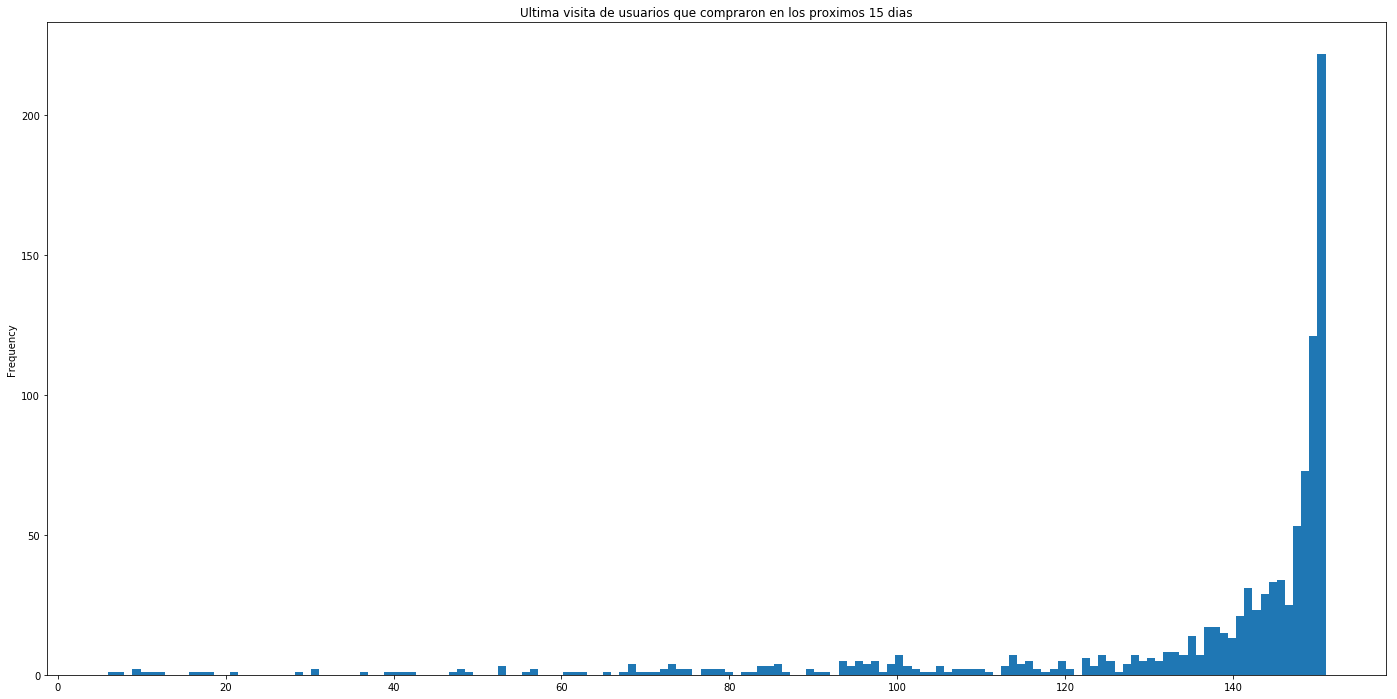

In [180]:
modelo[modelo['label']==1]['ultima_visita'].plot(kind='hist',figsize=(24,12),bins=150)
plt.title('Ultima visita de usuarios que compraron en los proximos 15 dias')

Text(0.5,1,'Ultima visita de usuarios que no compraron en los proximos 15 dias')

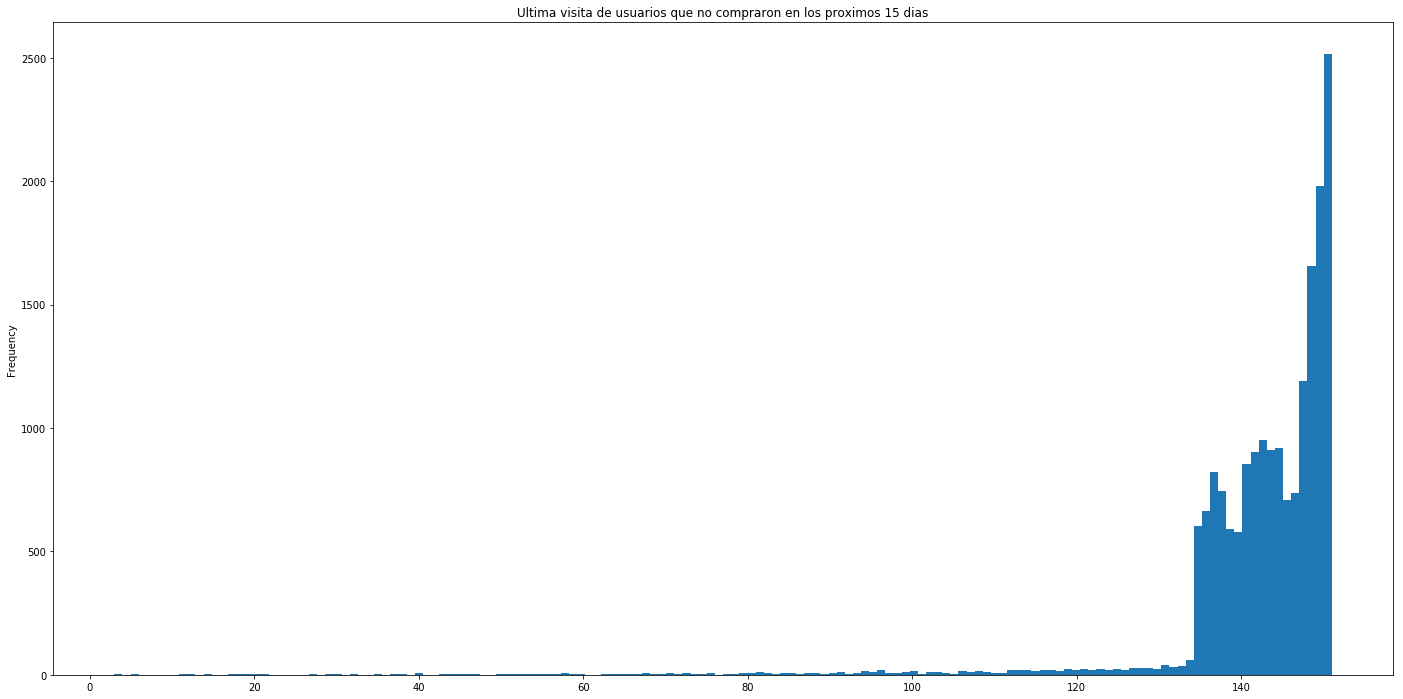

In [181]:
modelo[modelo['label']==0]['ultima_visita'].plot(kind='hist',figsize=(24,12),bins=150)
plt.title('Ultima visita de usuarios que no compraron en los proximos 15 dias')

### Usuarios cuya ultima visita es antes de mayo solo habian entrado una vez

In [182]:
modelo.loc[(modelo['ultima_visita']<120)&(modelo['label']==1)]['dias_distintos'].nunique() 

1

In [183]:
modelo.loc[(modelo['ultima_visita']<120)&(modelo['label']==0)]['dias_distintos'].nunique() 

1

### Cantidad de visitas por usuario

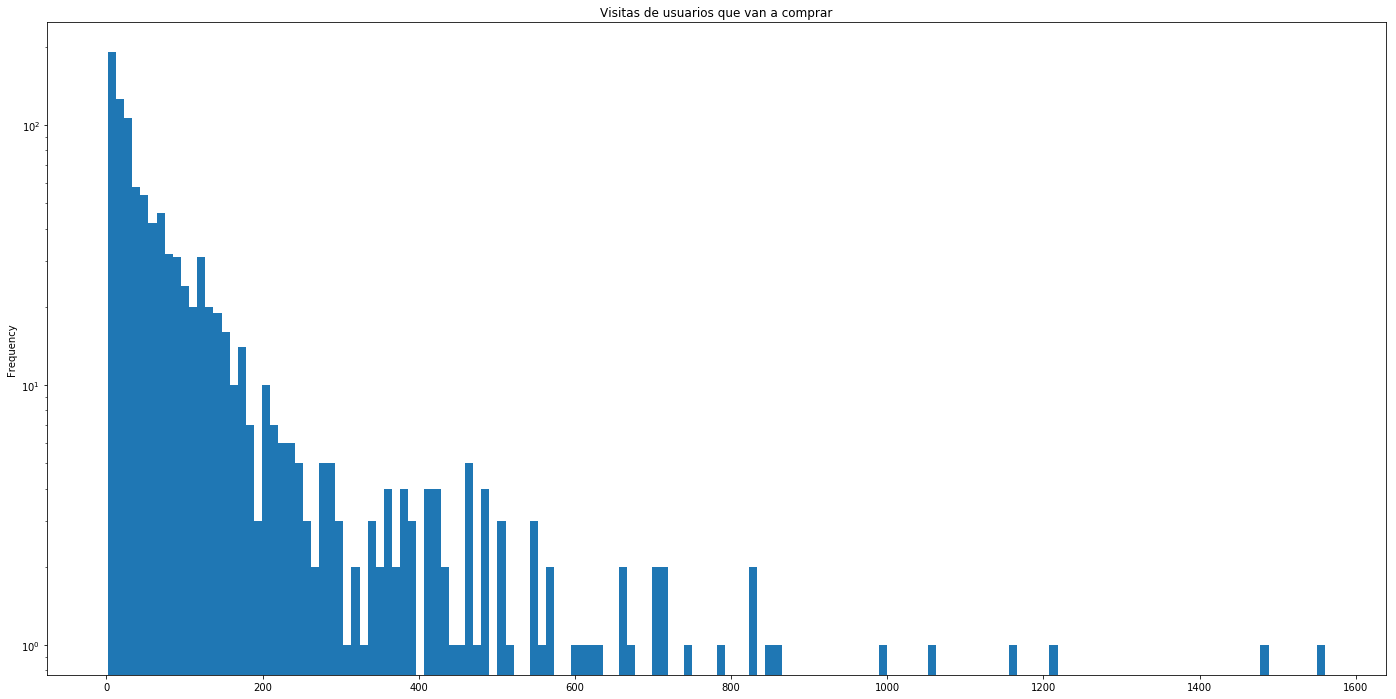

In [184]:
modelo[modelo['label']==1]['total_visitas_usuario'].plot(kind='hist',figsize=(24,12),bins=150)
plt.title('Visitas de usuarios que van a comprar')
plt.yscale('log', nonposy='clip')

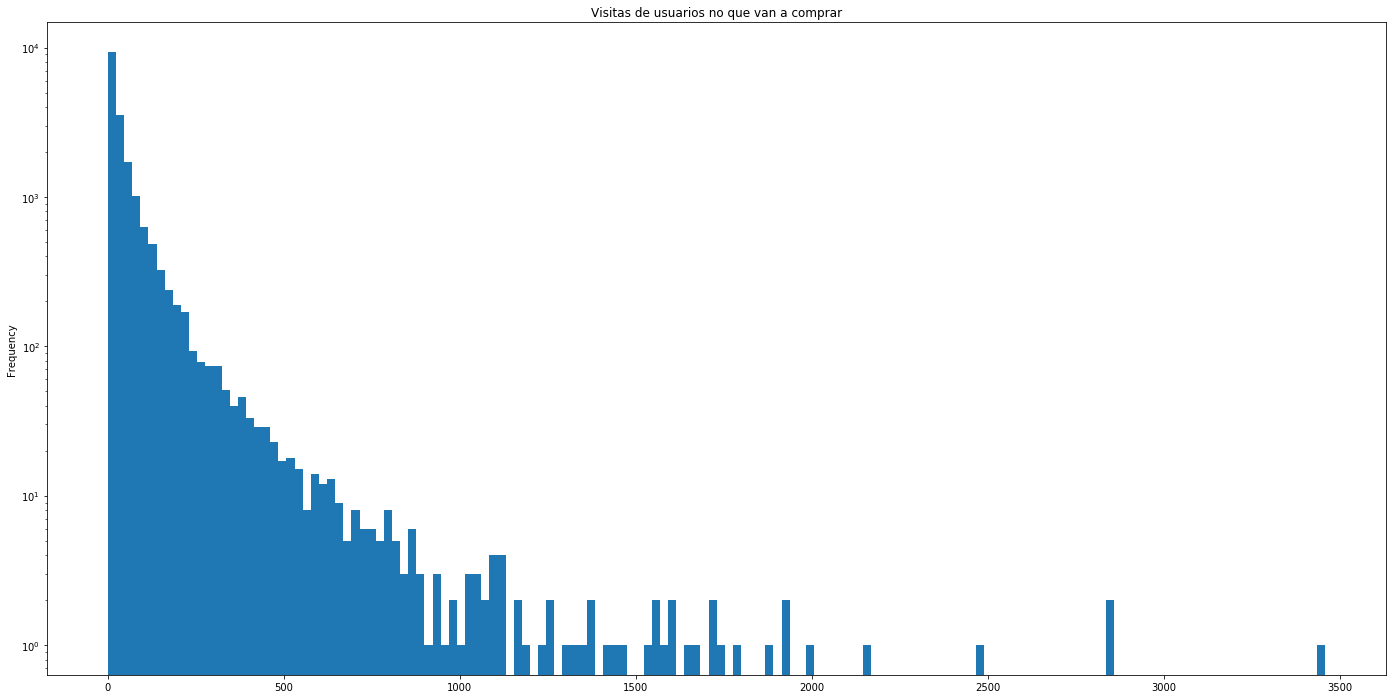

In [185]:
modelo[modelo['label']==0]['total_visitas_usuario'].plot(kind='hist',figsize=(24,12),bins=150)
plt.title('Visitas de usuarios no que van a comprar')
plt.yscale('log', nonposy='clip')

### Cantidad de visitas no decide si va a comprar o no

In [186]:
visitas={}
for i in range(100,3500,200):
    visitas[i]=[len(modelo.loc[(modelo['label']==0)&(modelo['total_visitas_usuario']>i)]),len(modelo.loc[(modelo['label']==1)&(modelo['total_visitas_usuario']>i)])]
visitas=pd.DataFrame(visitas)
visitas

,100,300,500,700,900,1100,1300,1500,1700,1900,2100,2300,2500,2700,2900,3100,3300
0,2635,545,208,106,59,43,28,21,13,8,5,4,3,3,1,1,1
1,280,78,33,16,6,4,2,1,0,0,0,0,0,0,0,0,0


### Cantidad de usuarios que visitaron por ultima vez la pagina antes de mayo, y realizaron una compra en los proximos 15 dias

In [187]:
len(modelo.loc[(modelo['ultima_visita']<120)&(modelo['label']==1)]) 

153

In [188]:
len(modelo.loc[(modelo['ultima_visita']<120)&(modelo['label']==0)]) 

673

### Cantidad de usuarios que visitaron por ultima vez la pagina en de mayo, y realizaron una compra en los proximos 15 dias

In [189]:
len(modelo.loc[(modelo['ultima_visita']>119)&(modelo['label']==1)]) 

827

In [190]:
len(modelo.loc[(modelo['ultima_visita']>119)&(modelo['label']==0)]) 

17761

### Usuarios que van a comprar tienen mayor promedio de modelos vistos

In [191]:
modelo[modelo['label']==1]['modelos_distintos_vistos'].mean(),modelo[modelo['label']==0]['modelos_distintos_vistos'].mean()

(8.989795918367347, 5.543723554301834)

### Promedio de usuarios que van a comprar es mayor si ingresaron a traves de una campaña 

In [192]:
modelo[modelo['label']==1]['campaña_ultima_semana'].mean(),modelo[modelo['label']==0]['campaña_ultima_semana'].mean()

(1.8622448979591837, 1.5189866550938482)

### Un 0.44% de las personas que van a comprar entraron a traves de una campaña

In [193]:
len(modelo.loc[(modelo['label']==1)&(modelo['campaña_ultima_semana']!=0)]),len(modelo.loc[(modelo['label']==0)&(modelo['campaña_ultima_semana']!=0)] )

(432, 8076)

In [194]:
100*len(modelo.loc[(modelo['label']==1)&(modelo['campaña_ultima_semana']!=0)]) /len(modelo[modelo['label']==1]),100*len(modelo.loc[(modelo['label']==0)&(modelo['campaña_ultima_semana']!=0)]) /len(modelo[modelo['label']==0])

(44.08163265306123, 43.81035043940545)

De las 432, 90 (20%) ya habian comprado. O mejor dicho, un 80% que no habia comprado, a traves de una campaña despues terminó comprando.

In [195]:
len(modelo.loc[(modelo['label']==1)&(modelo['campaña_ultima_semana']!=0)&(modelo['total_compras']!=0)])

90

### Un 20% de usuarios que van a comprar, ya lo habian hecho

In [196]:
len(modelo.loc[(modelo['label']==1)&(modelo['total_compras']>0)]), 100*len(modelo.loc[(modelo['label']==1)&(modelo['total_compras']>0)])/len(modelo[modelo['label']==1])

(197, 20.102040816326532)

Text(0.5,1,'Frecuencia de compras anteriores de usuarios que van a comprar')

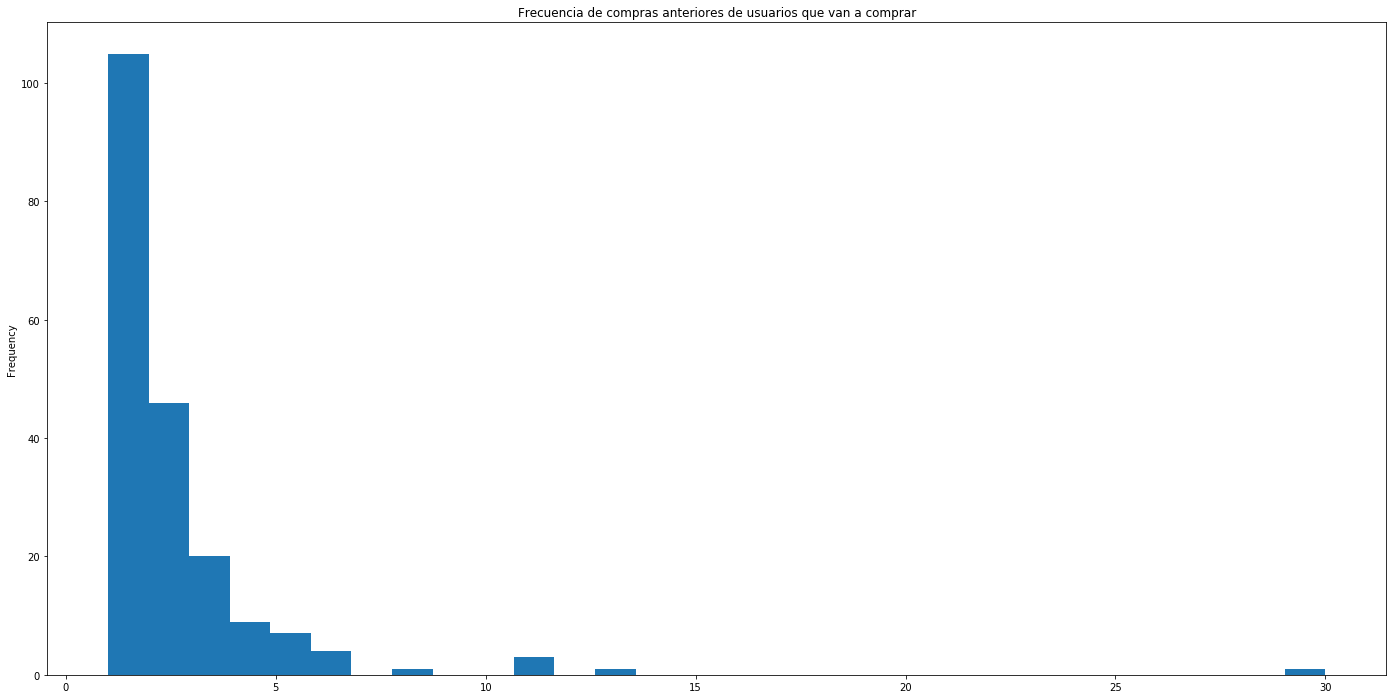

In [197]:
modelo.loc[(modelo['label']==1)&(modelo['total_compras']>0)]['total_compras'].plot(kind='hist',figsize=(24,12),bins=30)
plt.title('Frecuencia de compras anteriores de usuarios que van a comprar')

28 (2.8%) usuarios ya habian comprado antes de mayo. 

In [198]:
len(modelo.loc[(modelo['label']==1)&(modelo['total_compras']>0)&(modelo['ultima_visita']<120)])

28

Pero estos usuarios tenian una media de 129 visitas a la pagina

In [199]:
modelo.loc[(modelo['label']==1)&(modelo['total_compras']>0)&(modelo['ultima_visita']<120)]['total_visitas_usuario'].mean()

129.46428571428572

De los otros 169, su media de visitas a la pagina es de 240! Esto demuestra una tendencia a comprar.

In [200]:
modelo.loc[(modelo['label']==1)&(modelo['total_compras']>0)&(modelo['ultima_visita']>120)]['total_visitas_usuario'].mean()

240.92857142857142

Y su media de dias distintos es mayor a 6.

In [201]:
modelo.loc[(modelo['label']==1)&(modelo['total_compras']>0)&(modelo['ultima_visita']>120)]['dias_distintos'].mean()

6.232142857142857

141 es la media de aquellos que ya habian comprado, pero no lo hicieron luego.

In [202]:
modelo.loc[(modelo['label']==0)&(modelo['total_compras']>0)&(modelo['ultima_visita']>120)]['total_visitas_usuario'].mean()

141.05061983471074

Y para estos, la media de dias distintos es 5.

In [203]:
modelo.loc[(modelo['label']==0)&(modelo['total_compras']>0)&(modelo['ultima_visita']>120)]['dias_distintos'].mean()

5.037706611570248

## MACHINE LEARNING

In [204]:
##Ahora empieza ML

from sklearn.model_selection import train_test_split,GridSearchCV,StratifiedKFold,RandomizedSearchCV
from sklearn import metrics
from sklearn.metrics import accuracy_score, f1_score,precision_score,recall_score,roc_auc_score

## Split

In [205]:
X = modelo.drop(['person','label'], axis=1)
y = modelo['label']

## K-means

In [206]:
from sklearn.cluster import KMeans

In [207]:
kmeans_2 = KMeans(n_clusters=2, init='k-means++', n_jobs=8).fit(X)
X['kmeans_2'] = kmeans_2.labels_

In [208]:
kmeans_3 = KMeans(n_clusters=3, init='k-means++', n_jobs=8).fit(X)
X['kmeans_3'] = kmeans_3.labels_

In [209]:
kmeans_4 = KMeans(n_clusters=4, init='k-means++', n_jobs=8).fit(X)
X['kmeans_4'] = kmeans_4.labels_

In [210]:
kmeans_5 = KMeans(n_clusters=5, init='k-means++', n_jobs=8).fit(X)
X['kmeans_5'] = kmeans_5.labels_

In [211]:
kmeans_50 = KMeans(n_clusters=50, init='k-means++', n_jobs=8).fit(X)
X['kmeans_50'] = kmeans_50.labels_

In [212]:
kmeans_100 = KMeans(n_clusters=100, init='k-means++', n_jobs=8).fit(X)
X['kmeans_100'] = kmeans_100.labels_

## HDBScan

In [213]:
import hdbscan

clusterer = hdbscan.HDBSCAN(min_cluster_size=100)
cluster_labels = clusterer.fit_predict(X)
X['HDBScan'] = cluster_labels

## Feature importance con random forest

Feature ranking:
1. feature 17 (0.032528)
2. feature 41 (0.029526)
3. feature 55 (0.023694)
4. feature 35 (0.022058)
5. feature 42 (0.021126)
6. feature 54 (0.020264)
7. feature 43 (0.020188)
8. feature 44 (0.020020)
9. feature 45 (0.019877)
10. feature 18 (0.018770)
11. feature 33 (0.017779)
12. feature 15 (0.017753)
13. feature 47 (0.017753)
14. feature 23 (0.017730)
15. feature 91 (0.017650)
16. feature 90 (0.017242)
17. feature 19 (0.016992)
18. feature 1 (0.016712)
19. feature 89 (0.016554)
20. feature 97 (0.016433)
21. feature 8 (0.016306)
22. feature 11 (0.016266)
23. feature 46 (0.016192)
24. feature 16 (0.016137)
25. feature 2 (0.016057)
26. feature 21 (0.015977)
27. feature 6 (0.015972)
28. feature 25 (0.015876)
29. feature 3 (0.015781)
30. feature 96 (0.015567)
31. feature 20 (0.015550)
32. feature 88 (0.015165)
33. feature 27 (0.015014)
34. feature 26 (0.014363)
35. feature 32 (0.013297)
36. feature 12 (0.013077)
37. feature 4 (0.013041)
38. feature 31 (0.013017)
39. featur

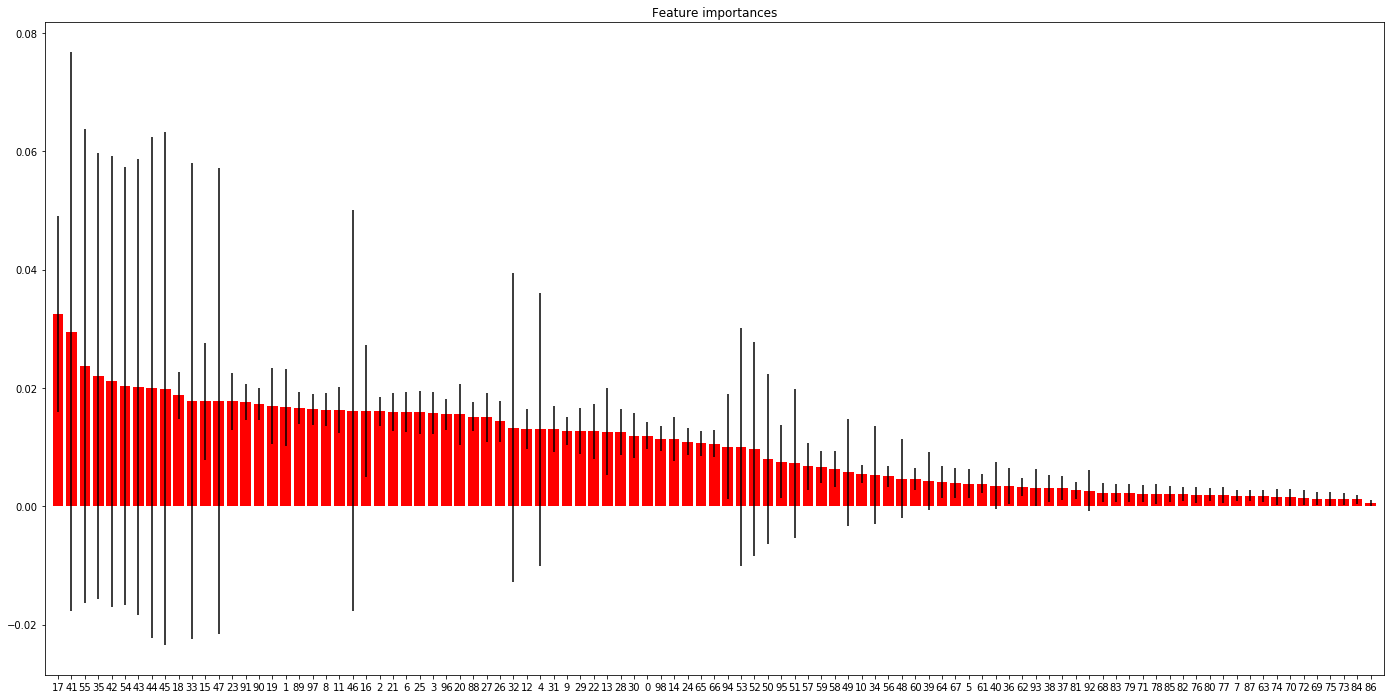

In [214]:
from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier
forest = ExtraTreesClassifier(n_estimators=500,
                              random_state=0,
                             class_weight ={1:8})
forest.fit(X, y)
def feature_importance(clasificador):
    importances = clasificador.feature_importances_
    std = np.std([tree.feature_importances_ for tree in clasificador.estimators_],
                 axis=0)
    indices = np.argsort(importances)[::-1]
    print("Feature ranking:")
    for f in range(X.shape[1]):
        print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))
    plt.figure(figsize=(24,12))
    plt.title("Feature importances")
    plt.bar(range(X.shape[1]), importances[indices],
           color="r", yerr=std[indices], align="center")
    plt.xticks(range(X.shape[1]), indices)
    plt.xlim([-1, X.shape[1]])
    plt.show()
feature_importance(forest)


## Select k best features

In [215]:
from sklearn.feature_selection import SelectKBest
model= SelectKBest(k='all').fit(X,y)
columnas=list(X.columns[model.get_support()])
columnas

['sku',
 'horas_distintas',
 'ad campaign hit',
 'brand listing',
 'checkout',
 'conversion',
 'generic listing',
 'lead',
 'search engine hit',
 'searched products',
 'staticpage',
 'viewed product',
 'visited site',
 'dias_distintos',
 'dias_distintos_ultima_semana',
 'dias_distintos_de_la_semana',
 'dias_distintos_de_la_semana_last_month',
 'ultima_visita',
 'compras_por_dia_semana',
 'modelos_distintos_vistos',
 'marcas_distintas',
 'celular_mas_visto',
 'modelos_por_color',
 'eventos_distintos',
 'campaña_ultima_semana',
 'total_visitas_usuario',
 'visitas_ultimo_mes',
 'visitas_ultimos_15',
 'visitas_ultima_semana',
 'visitas_ultimos_3',
 'visitas_ultimo_dia',
 'visitas_ultimos_2',
 'total_checkout',
 'checkouts_ultimo_mes',
 'checkouts_ultima_semana',
 'checkouts_ultimos_15',
 'checkouts_ultimos_3',
 'checkouts_ultimo_dia',
 'checkouts_ultimos_2',
 'checkouts_ultimos_5',
 'checkouts_ultimos_4',
 'checkouts_ultimos_16',
 'checkouts_ultimos_18',
 'checkouts_ultimos_20',
 'checkout

In [216]:
model=model.transform(X)

In [217]:
X = pd.DataFrame.from_records(model)
X.columns=columnas

In [218]:
import xgboost as xgb
data_dmatrix = xgb.DMatrix(data=X,label=y)

In [219]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2) 

In [220]:
len(X_train),len(X_test),len(y_train),len(y_test)

(15531, 3883, 15531, 3883)

In [221]:
X_train.head()

,sku,horas_distintas,ad campaign hit,brand listing,checkout,conversion,generic listing,lead,search engine hit,searched products,staticpage,viewed product,visited site,dias_distintos,dias_distintos_ultima_semana,dias_distintos_de_la_semana,dias_distintos_de_la_semana_last_month,ultima_visita,compras_por_dia_semana,modelos_distintos_vistos,marcas_distintas,celular_mas_visto,modelos_por_color,eventos_distintos,campaña_ultima_semana,total_visitas_usuario,visitas_ultimo_mes,visitas_ultimos_15,visitas_ultima_semana,visitas_ultimos_3,visitas_ultimo_dia,visitas_ultimos_2,total_checkout,checkouts_ultimo_mes,checkouts_ultima_semana,checkouts_ultimos_15,checkouts_ultimos_3,checkouts_ultimo_dia,checkouts_ultimos_2,checkouts_ultimos_5,checkouts_ultimos_4,checkouts_ultimos_16,checkouts_ultimos_18,checkouts_ultimos_20,checkouts_ultimos_22,checkouts_ultimos_24,checkouts_ultimos_26,checkouts_ultimos_28,checkouts_ultimos_6,checkouts_ultimos_8,checkouts_ultimos_9,checkouts_ultimos_10,checkouts_ultimos_11,checkouts_ultimos_12,checkouts_ultimos_14,checkouts_ultimos_17,checkouts_lunes,checkouts_martes,checkouts_miercoles,checkouts_jueves,checkouts_viernes,checkouts_sabado,checkouts_domingo,checkouts_finde,checkouts_semana,visitas_finde,visitas_semana,total_compras,compras_ultimo_mes,compras_ultima_semana,compras_ultimos_3,compras_ultimos_15,compras_ultimo_dia,compras_ultimos_2,compras_ultimos_5,compras_ultimos_4,compras_ultimos_20,compras_ultimos_21,compras_ultimos_22,compras_ultimos_25,compras_lunes,compras_martes,compras_miercoles,compras_jueves,compras_viernes,compras_sabado,compras_domingo,subscripciones,precio_max,precio_mean,precio_std,precio_min,kmeans_2,kmeans_3,kmeans_4,kmeans_5,kmeans_50,kmeans_100,HDBScan
15537,0,2,1,0,1,0,1,0,1,4,0,5,2,2,0,2,2,139,19185,2,1,5,0,7,0,15,15,15,0,0,0,0,1,1,0,1,0,0,0,0,0,1,1,1,1,1,1,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1275,1178,217,669,0,0,0,0,17,59,-1
7082,0,1,2,0,1,0,0,0,2,0,0,2,1,1,0,1,1,139,4728,1,1,3,0,5,0,8,8,8,0,0,0,0,1,1,0,1,0,0,0,0,0,1,1,1,1,1,1,1,0,0,0,0,0,1,1,1,0,0,0,0,0,1,0,0,0,8,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1275,1275,0,1275,0,0,0,0,36,80,-1
13694,0,1,1,0,1,0,0,0,0,0,0,1,1,1,1,1,1,147,1880,1,1,2,0,4,1,4,4,4,4,0,0,0,1,1,1,1,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,1,0,0,4,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1275,1275,0,1275,0,0,0,0,36,8,12
17153,0,4,4,0,0,0,4,0,4,0,0,29,5,4,0,4,4,127,31037,5,1,8,0,5,0,46,46,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,45,45,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3009,1797,686,619,0,0,0,0,26,71,-1
697,9272,2,2,0,1,0,0,0,1,0,0,11,2,1,0,2,1,138,22439,2,1,10,0,5,0,17,4,4,0,0,0,0,1,1,0,1,0,0,0,0,0,1,1,1,1,1,1,1,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,4,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1275,1211,181,730,0,0,0,0,38,97,0


In [222]:
y_train.head()

31192    0
14350    0
27546    0
34400    1
1382     0
Name: label, dtype: int64

### Graficador del ROC AUC 

In [223]:
from sklearn.metrics import roc_curve, auc
def graficar_roc(clasificador):
    fpr = dict()
    tpr = dict()
    fpr, tpr, _ = roc_curve(y_test, clasificador.predict_proba(X_test)[:,1])
    roc_auc = dict()
    roc_auc = auc(fpr, tpr)

    # make the plot
    plt.figure(figsize=(10,10))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([-0.05, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.grid(True)
    plt.plot(fpr, tpr, label='AUC = {0}'.format(roc_auc), linewidth =3)        
    plt.legend(loc="lower right", shadow=True, fancybox =True) 
    plt.show()

## Algoritmos de clasificación

## XGBOOST

In [224]:
my_classifier1 = xgb.XGBClassifier(objective ='binary:logistic',max_depth =1,learning_rate = 0.02, n_estimators = 500,scale_pos_weight=7)
my_classifier1.fit(X_train,y_train)
predictions=my_classifier1.predict(X_test)
metrics.confusion_matrix(y_test, predictions)

/home/julianferres/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


array([[3249,  440],
       [  73,  121]])

In [225]:
accuracy_score(y_test, predictions),roc_auc_score(y_test,  my_classifier1.predict_proba(X_test)[:,1])

(0.8678856554210662, 0.8662679238639253)

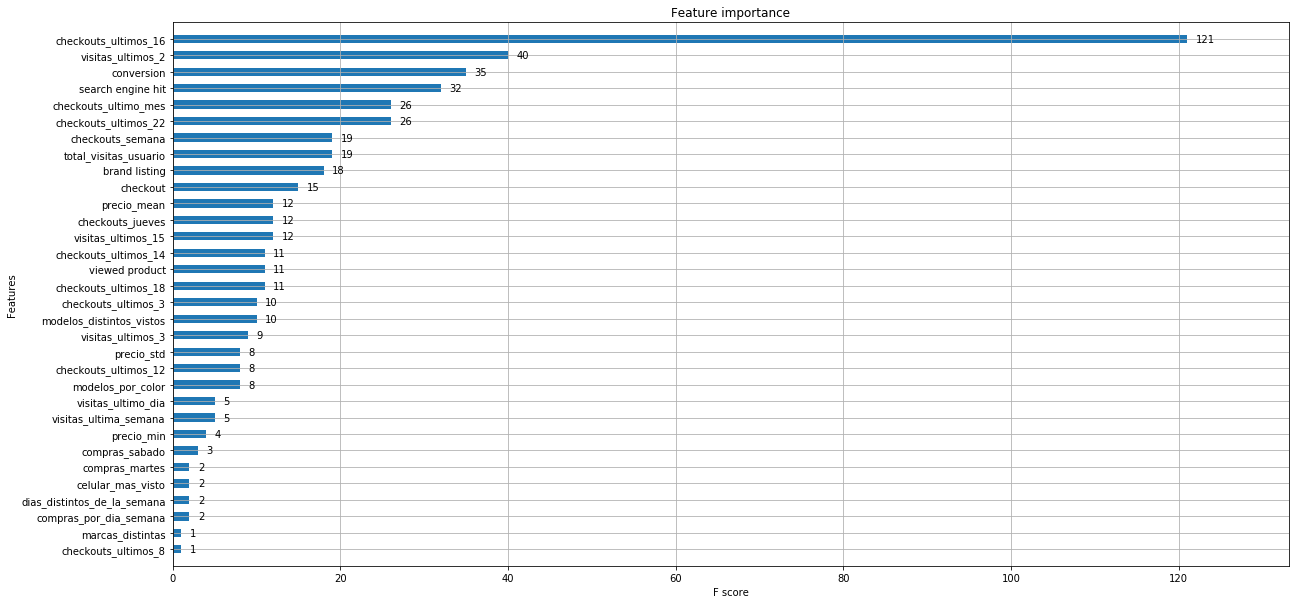

In [226]:
from xgboost import plot_importance
ax = plot_importance(my_classifier1,height=0.5)
fig = ax.figure
fig.set_size_inches(20,10)
plt.show()

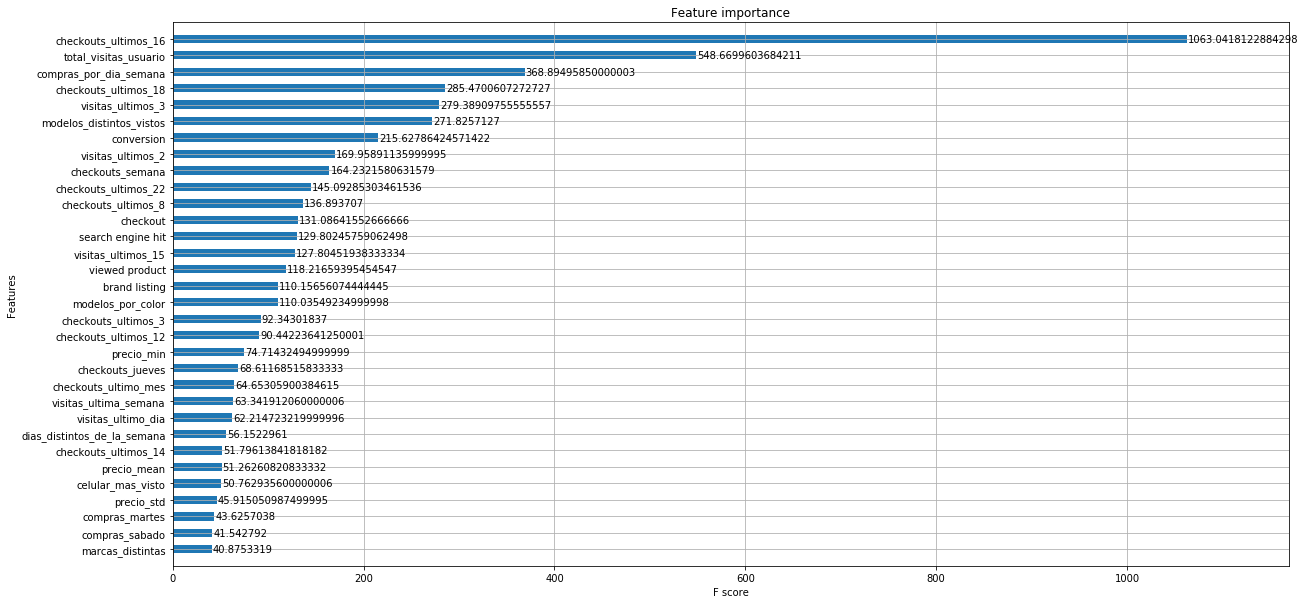

In [227]:
ax = plot_importance(my_classifier1,height=0.5,importance_type='gain')
fig = ax.figure
fig.set_size_inches(20,10)
plt.show()

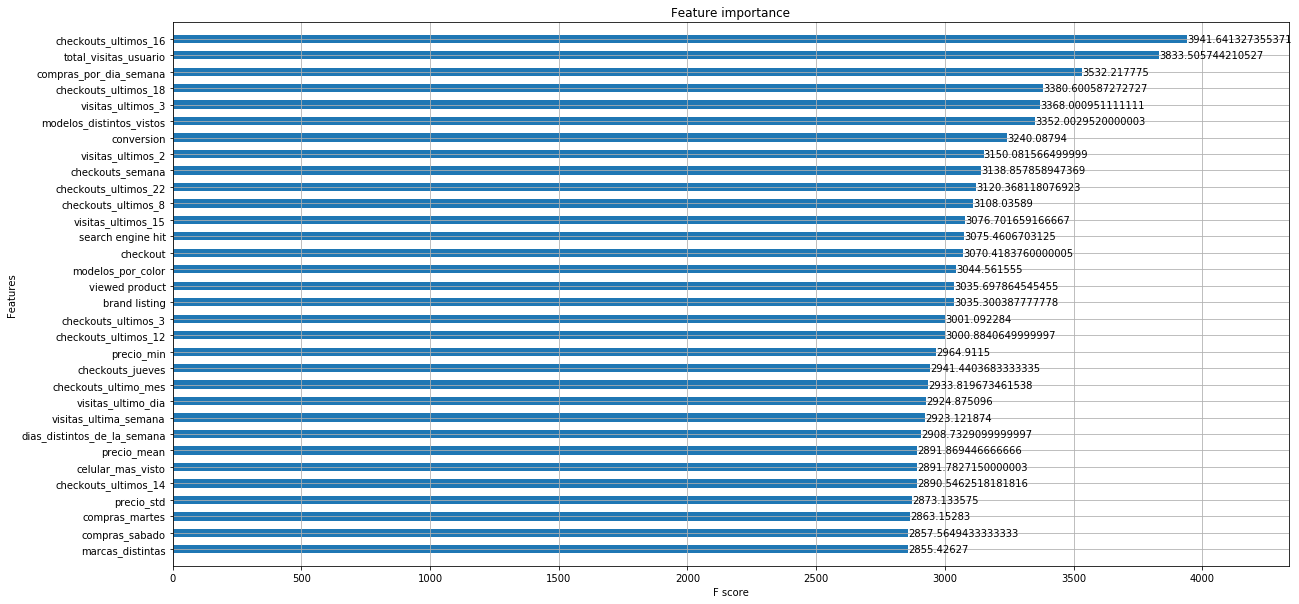

In [228]:
ax = plot_importance(my_classifier1,height=0.5,importance_type='cover')
fig = ax.figure
fig.set_size_inches(20,10)
plt.show()

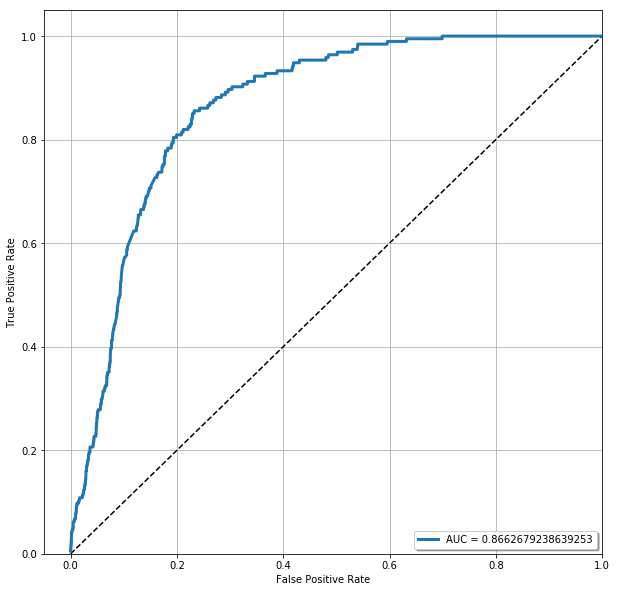

In [229]:
graficar_roc(my_classifier1)

## LightGBM

In [230]:
import lightgbm as lgb
my_classifier2 = lgb.LGBMClassifier(   
        objective='binary',
        boosting='goss',
        scale_pos_weight=8,
        n_estimators=13000,
        learning_rate=0.001,
        max_depth=1, 
        num_threads =6,        
    )

my_classifier2.fit(X_train,y_train)
predictions=my_classifier2.predict(X_test)
metrics.confusion_matrix(y_test, predictions)

/home/julianferres/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


array([[3191,  498],
       [  68,  126]])

In [231]:
accuracy_score(y_test, predictions),roc_auc_score(y_test,  my_classifier2.predict_proba(X_test)[:,1])

(0.8542364151429307, 0.8667227449676245)

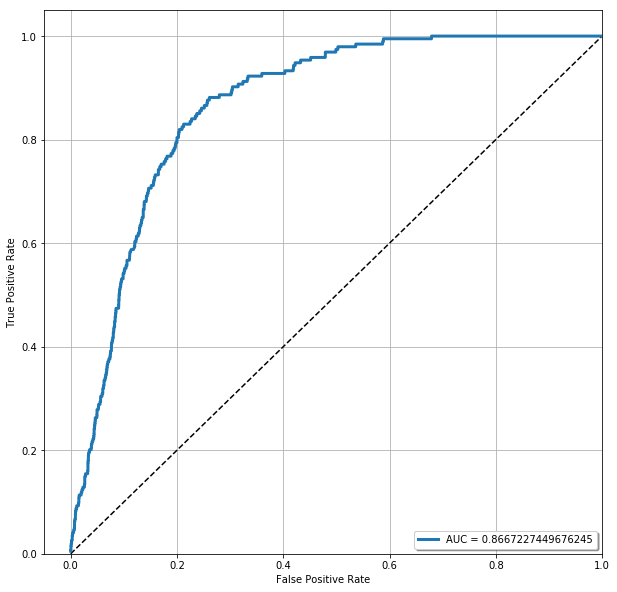

In [232]:
graficar_roc(my_classifier2)

## RANDOM FOREST

In [233]:
from sklearn.ensemble import RandomForestClassifier #a mayor depth, mas precisos los 0, menos los 1,class weight cambia mucho
my_classifier3 = RandomForestClassifier(criterion= 'entropy',max_depth= 5,n_estimators=1000, max_features= 'auto', class_weight={1:9} ,n_jobs=-1)
my_classifier3.fit(X_train,y_train)
predictions=my_classifier3.predict(X_test)
metrics.confusion_matrix(y_test, predictions)

array([[3110,  579],
       [  56,  138]])

In [234]:
accuracy_score(y_test, predictions),roc_auc_score(y_test,  my_classifier3.predict_proba(X_test)[:,1])

(0.836466649497811, 0.8672579108131447)

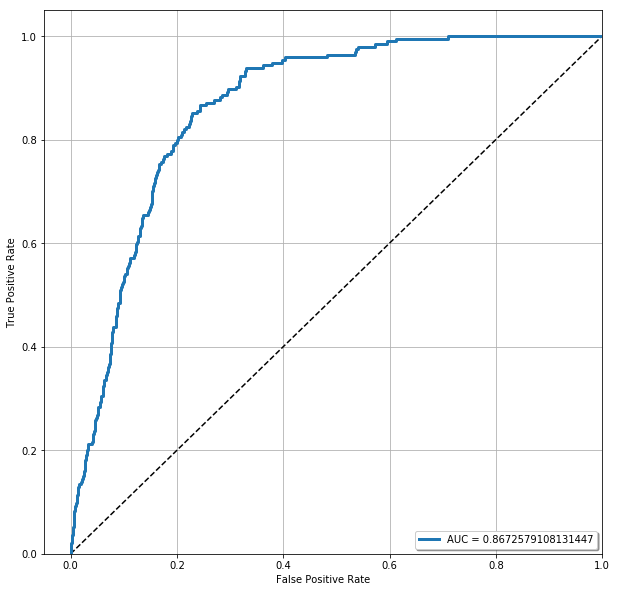

In [235]:
graficar_roc(my_classifier3)

Feature ranking:
1. feature 41 (0.083921)
2. feature 55 (0.078140)
3. feature 42 (0.070791)
4. feature 43 (0.053269)
5. feature 44 (0.052538)
6. feature 47 (0.050257)
7. feature 46 (0.045138)
8. feature 45 (0.044105)
9. feature 33 (0.038626)
10. feature 18 (0.027967)
11. feature 32 (0.025488)
12. feature 35 (0.024590)
13. feature 4 (0.024143)
14. feature 54 (0.022829)
15. feature 25 (0.021947)
16. feature 11 (0.018153)
17. feature 26 (0.017406)
18. feature 28 (0.014972)
19. feature 21 (0.013455)
20. feature 29 (0.012966)
21. feature 31 (0.012602)
22. feature 27 (0.012154)
23. feature 53 (0.011840)
24. feature 23 (0.011324)
25. feature 19 (0.010059)
26. feature 17 (0.009770)
27. feature 1 (0.009487)
28. feature 67 (0.008915)
29. feature 5 (0.007771)
30. feature 52 (0.007696)
31. feature 30 (0.007274)
32. feature 12 (0.006891)
33. feature 94 (0.006867)
34. feature 64 (0.006545)
35. feature 95 (0.006460)
36. feature 51 (0.005965)
37. feature 3 (0.005843)
38. feature 6 (0.005074)
39. featu

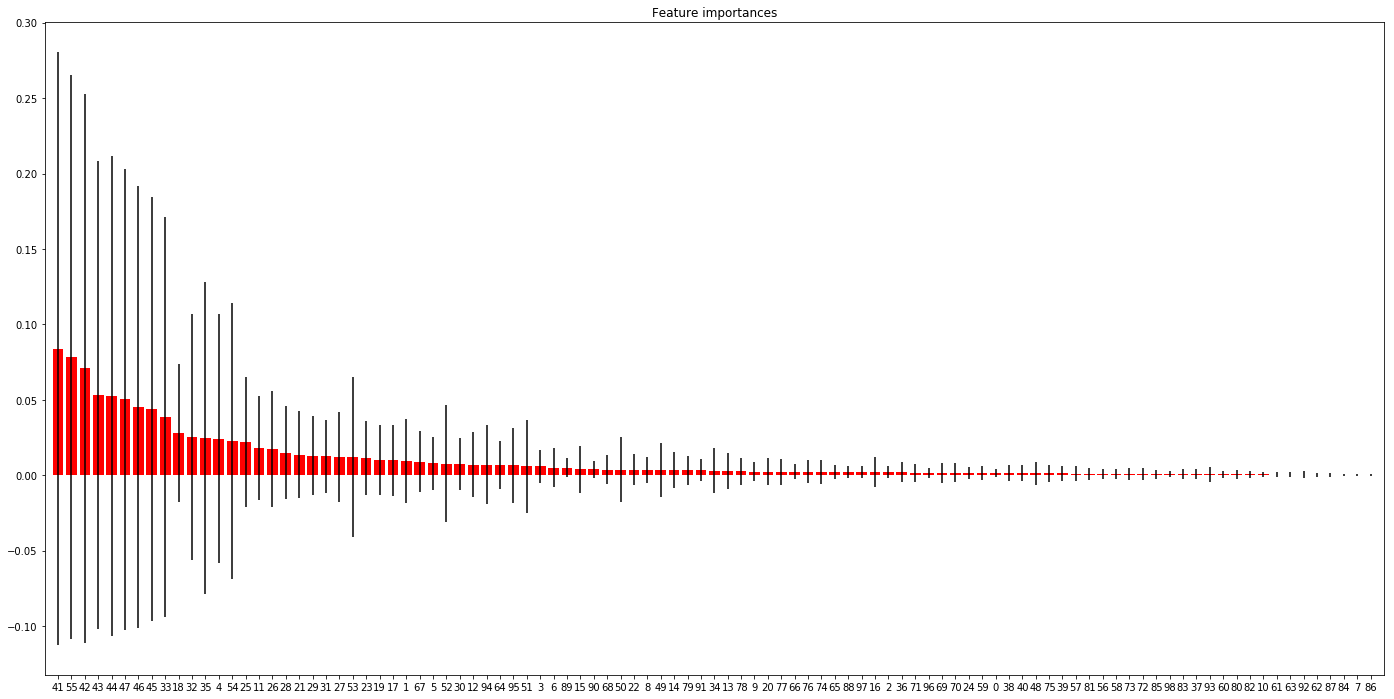

In [236]:
feature_importance(my_classifier3)

## Cat Boost

In [237]:
from catboost import CatBoostClassifier
my_classifier4=CatBoostClassifier(class_weights=[1, 8] ,logging_level='Silent',thread_count=6,boosting_type='Ordered',loss_function='Logloss',depth=3,leaf_estimation_method ='Newton',
                                 l2_leaf_reg = 23,od_pval=0.0000001)
my_classifier4.fit(X_train,y_train)
predictions=my_classifier4.predict(X_test)
metrics.confusion_matrix(y_test, predictions)

array([[3158,  531],
       [  63,  131]])

In [238]:
accuracy_score(y_test, predictions),roc_auc_score(y_test,  my_classifier4.predict_proba(X_test)[:,1])

(0.8470254957507082, 0.8634335011024696)

y_pred=0.0
for i in range(10):
    clf=CatBoostClassifier(class_weights=[1, 8] ,logging_level='Silent',thread_count=6,boosting_type='Ordered',loss_function='Logloss',depth=3,leaf_estimation_method ='Newton',
                                 l2_leaf_reg = 23,od_pval=0.0000001,random_seed=i+200)
    fit_model = clf.fit(X_train,y_train)
    y_pred +=  fit_model.predict_proba(X_test)[:,1]
y_pred /= 10

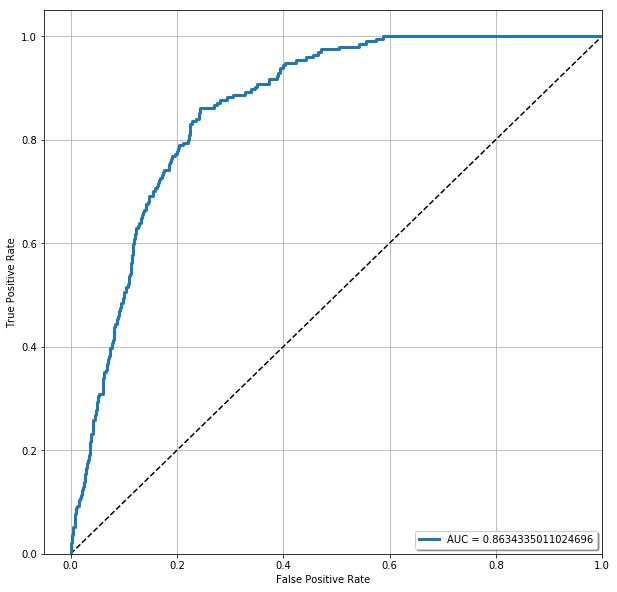

In [239]:
graficar_roc(my_classifier4)

## Voting classifier

In [240]:
from sklearn.ensemble import VotingClassifier
vclf = VotingClassifier(estimators=[ ('XGB', my_classifier1), ('GBM', my_classifier2),('RF', my_classifier3),('CB', my_classifier4)], voting='soft', n_jobs =-1)
vclf = vclf.fit(X_train, y_train)
predictions = vclf.predict(X_test)
metrics.confusion_matrix(y_test, predictions)

/home/julianferres/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


array([[3182,  507],
       [  62,  132]])

In [241]:
accuracy_score(y_test, predictions),roc_auc_score(y_test,  vclf.predict_proba(X_test)[:,1])

(0.8534638166366212, 0.8687851595576708)

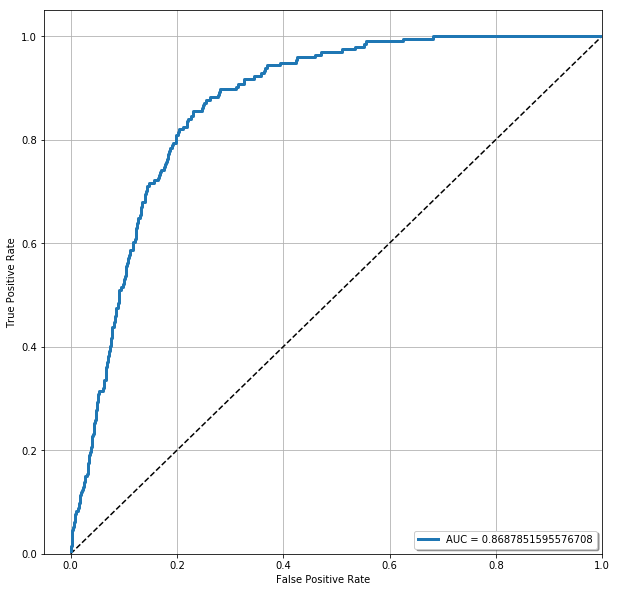

In [242]:
graficar_roc(vclf)

## KAGGLE PREDICTIONS

In [243]:
kaggle= pd.read_csv('data/kaggle.csv',low_memory=False)
kaggle=pd.merge(kaggle, a_predecir, on='person', how='inner')

In [244]:
kaggle2=kaggle.loc[:,columnas]
kaggle2 = kaggle2.fillna(0)
kaggle2.head()

/home/julianferres/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


,sku,horas_distintas,ad campaign hit,brand listing,checkout,conversion,generic listing,lead,search engine hit,searched products,staticpage,viewed product,visited site,dias_distintos,dias_distintos_ultima_semana,dias_distintos_de_la_semana,dias_distintos_de_la_semana_last_month,ultima_visita,compras_por_dia_semana,modelos_distintos_vistos,marcas_distintas,celular_mas_visto,modelos_por_color,eventos_distintos,campaña_ultima_semana,total_visitas_usuario,visitas_ultimo_mes,visitas_ultimos_15,visitas_ultima_semana,visitas_ultimos_3,visitas_ultimo_dia,visitas_ultimos_2,total_checkout,checkouts_ultimo_mes,checkouts_ultima_semana,checkouts_ultimos_15,checkouts_ultimos_3,checkouts_ultimo_dia,checkouts_ultimos_2,checkouts_ultimos_5,checkouts_ultimos_4,checkouts_ultimos_16,checkouts_ultimos_18,checkouts_ultimos_20,checkouts_ultimos_22,checkouts_ultimos_24,checkouts_ultimos_26,checkouts_ultimos_28,checkouts_ultimos_6,checkouts_ultimos_8,checkouts_ultimos_9,checkouts_ultimos_10,checkouts_ultimos_11,checkouts_ultimos_12,checkouts_ultimos_14,checkouts_ultimos_17,checkouts_lunes,checkouts_martes,checkouts_miercoles,checkouts_jueves,checkouts_viernes,checkouts_sabado,checkouts_domingo,checkouts_finde,checkouts_semana,visitas_finde,visitas_semana,total_compras,compras_ultimo_mes,compras_ultima_semana,compras_ultimos_3,compras_ultimos_15,compras_ultimo_dia,compras_ultimos_2,compras_ultimos_5,compras_ultimos_4,compras_ultimos_20,compras_ultimos_21,compras_ultimos_22,compras_ultimos_25,compras_lunes,compras_martes,compras_miercoles,compras_jueves,compras_viernes,compras_sabado,compras_domingo,subscripciones,precio_max,precio_mean,precio_std,precio_min,kmeans_2,kmeans_3,kmeans_4,kmeans_5,kmeans_50,kmeans_100,HDBScan
0,9288,1,0,0,1,0,1,0,1,1,0,4,1,1,0,1,1,138,8046,1,1,5,0,6,0,9,9,9,0,0,0,0,1,1,0,1,0,0,0,0,0,1,1,1,1,1,1,1,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,9,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1275,972,287,730,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,6888,22,29,4,7,0,21,1,0,6,0,404,95,15,4,7,6,148,618857,15,3,219,1,8,1,567,173,126,53,8,0,0,7,2,0,1,0,0,0,0,0,1,1,1,2,2,2,2,0,0,1,1,1,1,1,1,0,1,1,2,0,0,3,0,0,30,30,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,3009,1406,448,619,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,11890,2,1,5,1,0,1,0,2,1,0,13,2,2,1,2,2,147,16460,3,2,6,0,8,1,26,26,26,16,0,0,0,1,1,1,1,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,1,0,0,26,26,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2469,1550,512,1275,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,9274,13,15,7,1,0,20,0,26,1,5,739,22,13,4,6,6,151,924152,57,7,253,1,9,5,836,836,449,270,252,184,184,1,1,0,0,0,0,0,0,0,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,166,166,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2099,1184,213,379,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,312,11,14,8,2,0,14,0,13,9,0,177,20,5,0,5,5,142,198938,9,2,84,1,8,0,257,257,257,0,0,0,0,2,2,0,2,0,0,0,0,0,2,2,2,2,2,2,2,0,0,0,0,0,1,2,2,0,0,0,0,1,1,0,0,0,242,242,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2469,1311,457,550,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [245]:
kmeans_2 = KMeans(n_clusters=2, init='k-means++', n_jobs=8).fit(kaggle2)
kaggle2['kmeans_2'] = kmeans_2.labels_
kmeans_3 = KMeans(n_clusters=3, init='k-means++', n_jobs=8).fit(kaggle2)
kaggle2['kmeans_3'] = kmeans_3.labels_
kmeans_4 = KMeans(n_clusters=4, init='k-means++', n_jobs=8).fit(kaggle2)
kaggle2['kmeans_4'] = kmeans_4.labels_
kmeans_5 = KMeans(n_clusters=5, init='k-means++', n_jobs=8).fit(kaggle2)
kaggle2['kmeans_5'] = kmeans_5.labels_

clusterer = hdbscan.HDBSCAN(min_cluster_size=100)
cluster_labels = clusterer.fit_predict(kaggle2)
kaggle2['HDBScan'] = cluster_labels

In [246]:
kaggle2.columns

Index(['sku', 'horas_distintas', 'ad campaign hit', 'brand listing',
       'checkout', 'conversion', 'generic listing', 'lead',
       'search engine hit', 'searched products', 'staticpage',
       'viewed product', 'visited site', 'dias_distintos',
       'dias_distintos_ultima_semana', 'dias_distintos_de_la_semana',
       'dias_distintos_de_la_semana_last_month', 'ultima_visita',
       'compras_por_dia_semana', 'modelos_distintos_vistos',
       'marcas_distintas', 'celular_mas_visto', 'modelos_por_color',
       'eventos_distintos', 'campaña_ultima_semana', 'total_visitas_usuario',
       'visitas_ultimo_mes', 'visitas_ultimos_15', 'visitas_ultima_semana',
       'visitas_ultimos_3', 'visitas_ultimo_dia', 'visitas_ultimos_2',
       'total_checkout', 'checkouts_ultimo_mes', 'checkouts_ultima_semana',
       'checkouts_ultimos_15', 'checkouts_ultimos_3', 'checkouts_ultimo_dia',
       'checkouts_ultimos_2', 'checkouts_ultimos_5', 'checkouts_ultimos_4',
       'checkouts_ultimos_16

In [247]:
vclf = VotingClassifier(estimators=[  ('XGB', my_classifier1), ('GBM', my_classifier2),('RF', my_classifier3),('CB', my_classifier4)], voting='soft', n_jobs =-1)
vclf = vclf.fit(X, y)

In [248]:
predictions=vclf.predict_proba(kaggle2)

In [249]:
kaggle['prediction0'] = predictions[:,0]
kaggle['label'] = predictions[:,1]

In [251]:
kaggle.head(15)

,person,sku,horas_distintas,ad campaign hit,brand listing,checkout,conversion,generic listing,lead,search engine hit,searched products,staticpage,viewed product,visited site,dias_distintos,dias_distintos_ultima_semana,dias_distintos_de_la_semana,dias_distintos_de_la_semana_last_month,ultima_visita,compras_por_dia_semana,modelos_distintos_vistos,marcas_distintas,celular_mas_visto,modelos_por_color,eventos_distintos,campaña_ultima_semana,total_visitas_usuario,visitas_ultimo_mes,visitas_ultimos_15,visitas_ultima_semana,visitas_ultimos_3,visitas_ultimo_dia,visitas_ultimos_2,total_checkout,checkouts_ultimo_mes,checkouts_ultima_semana,checkouts_ultimos_15,checkouts_ultimos_3,checkouts_ultimo_dia,checkouts_ultimos_2,checkouts_ultimos_5,checkouts_ultimos_4,checkouts_ultimos_16,checkouts_ultimos_18,checkouts_ultimos_20,checkouts_ultimos_22,checkouts_ultimos_24,checkouts_ultimos_26,checkouts_ultimos_28,checkouts_ultimos_6,checkouts_ultimos_8,checkouts_ultimos_9,checkouts_ultimos_10,checkouts_ultimos_11,checkouts_ultimos_12,checkouts_ultimos_14,checkouts_ultimos_17,checkouts_lunes,checkouts_martes,checkouts_miercoles,checkouts_jueves,checkouts_viernes,checkouts_sabado,checkouts_domingo,checkouts_finde,checkouts_semana,visitas_finde,visitas_semana,total_compras,compras_ultimo_mes,compras_ultima_semana,compras_ultimos_3,compras_ultimos_15,compras_ultimo_dia,compras_ultimos_2,compras_ultimos_5,compras_ultimos_4,compras_ultimos_20,compras_ultimos_21,compras_ultimos_22,compras_ultimos_25,compras_lunes,compras_martes,compras_miercoles,compras_jueves,compras_viernes,compras_sabado,compras_domingo,subscripciones,precio_max,precio_mean,precio_std,precio_min,label,prediction0
0,4886f805,9288,1,0,0,1,0,1,0,1,1,0,4,1,1,0,1,1,138,8046,1,1,5,0,6,0,9,9,9,0,0,0,0,1,1,0,1,0,0,0,0,0,1,1,1,1,1,1,1,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,9,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1275,972,287,730,0.045719,0.954281
1,0297fc1e,6888,22,29,4,7,0,21,1,0,6,0,404,95,15,4,7,6,148,618857,15,3,219,1,8,1,567,173,126,53,8,0,0,7,2,0,1,0,0,0,0,0,1,1,1,2,2,2,2,0,0,1,1,1,1,1,1,0,1,1,2,0,0,3,0,0,30,30,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,3009,1406,448,619,0.165636,0.834364
2,2d681dd8,11890,2,1,5,1,0,1,0,2,1,0,13,2,2,1,2,2,147,16460,3,2,6,0,8,1,26,26,26,16,0,0,0,1,1,1,1,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,1,0,0,26,26,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2469,1550,512,1275,0.061401,0.938599
3,cccea85e,9274,13,15,7,1,0,20,0,26,1,5,739,22,13,4,6,6,151,924152,57,7,253,1,9,5,836,836,449,270,252,184,184,1,1,0,0,0,0,0,0,0,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,166,166,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2099,1184,213,379,0.658297,0.341703
4,4c8a8b93,312,11,14,8,2,0,14,0,13,9,0,177,20,5,0,5,5,142,198938,9,2,84,1,8,0,257,257,257,0,0,0,0,2,2,0,2,0,0,0,0,0,2,2,2,2,2,2,2,0,0,0,0,0,1,2,2,0,0,0,0,1,1,0,0,0,242,242,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2469,1311,457,550,0.163329,0.836671
5,29ebb414,0,4,4,0,1,0,3,0,4,11,0,8,4,2,0,2,2,140,27474,3,1,7,0,7,0,35,35,35,0,0,0,0,1,1,0,1,0,0,0,0,0,1,1,1,1,1,1,1,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,35,35,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2199,1415,330,1069,0.062508,0.937492
6,3dc1950f,304,15,3,6,3,0,25,0,7,2,1,595,30,11,2,5,5,149,819398,56,7,95,2,9,1,672,287,235,62,5,0,5,3,2,0,2,0,0,0,0,0,2,2,2,2,2,2,2,0,0,0,0,0,0,1,2,0,1,1,0,1,0,0,0,0,57,57,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2869,1144,398,319,0.194454,0.805546
7,8ea4c165,9273,8,13,5,3,0,8,0,9,17,0,97,7,3,0,4,3,139,176726,15,3,29,1,8,0,159,131,39,0,0,0,0,3,2,0,0,0,0,0,0,0,2,2,2,2,2,2,2,0,0,0,0,0,0,0,2,0,2,0,0,0,0,1,0,0,39,39,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3559,1183,505,669,0.157525,0.842475
8,d8cfe234,0,4,0,4,3,1,1,0,2,8,0,39,4,4,0,4,4,142,63370,7,1,16,1,8,0,62,53,53,0,0,0,0,3,2,0,2,0,0,0,0,0,2,2,2,2,2,2,2,0,0,1,2,2,2,2,2,1,2,0,0,0,0,0,0,1,20,20,1,1,0,0,1,0,0,0,0,1,1,1,1,0,1,0,0,0,0,0,0,1275,916,342,439,0.188437,0.811563
9,d6bc64df,2693,8,10,0,2,0,12,0,8,19,0,155,7,3,0,5,2,138,178459,13,3,70,0,7,0,213,98,86,0,0,0,0,2,1,0,1,0,0,0,0,0,1,

In [250]:
kaggle[['person','label']].to_csv('predicciones11.csv', encoding='utf-8', index=False)